# Importing the required modules

In [1]:
!pip install split-folders

In [2]:
# Module used for interacting with the file system.
import os
import json

# Modules used for data handling and manipulation
import pandas as pd
import numpy as np

# Modules used for data visualization
import matplotlib.pyplot as plt
import matplotlib.colors as clr
import matplotlib.image as mpimg
import seaborn as sns
sns.set_style("whitegrid")

# Modules used for random number choice
import random as r

# Module used to split train-test split
import splitfolders

# Modules used for model training and transfer learning
import tensorflow as tf
from tensorflow.keras.layers import Dense,Flatten, Dropout, BatchNormalization
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
import tensorflow.keras.applications as cnns
from tensorflow.keras import Model

# For graph visualization
import networkx as nx
from networkx.algorithms import bipartite

# Modules used for model evaluation and selection.
from sklearn.metrics import accuracy_score, classification_report, f1_score, recall_score, precision_score

# Module for suppressing warnings.
import warnings 
warnings.filterwarnings('ignore')

# Constants
malimg_dir = "/kaggle/input/malimg-dataset9010/dataset_9010/dataset_9010/malimg_dataset/"
malevis_dir = "/kaggle/input/malevis-dataset/malevis_train_val_300x300/"
blended_data_dir = "/kaggle/input/blended-malware-image-dataset/malware_dataset/"

The dataset already comprises train and validation directories with images for each malware. However, we need split the train data images into a train and test dataset for evaluation of the models being trained. Hence, the class takes three inputs: directory of the dataset, percentage of train images, and percentage of test images.

# Exploratory Data Analysis

In [3]:
# A class for loading a image dataset and understanding its class distribution
# and image samples across classes.
class MalwareImages:
    
    # Initialize the dataset loader with the dataset path.
    def __init__(self, DATA_DIR : str, n : int):
        self.DATA_DIR = DATA_DIR
        self.class_distribution = dict()
        self.ROWS = n
        self.COLS = n
    
    # Computation of the class distribution of the dataset.
    def __compute_class_distribution(self):
        for malware_type in os.listdir(self.DATA_DIR):
            malware_img_dir = os.path.join(self.DATA_DIR, malware_type)
            self.class_distribution[malware_type] = len(os.listdir(malware_img_dir))
    
    # Plotting the class distribution.
    def plot_class_distribution(self):
        self.__compute_class_distribution()

        malware_classes = list(self.class_distribution.keys())
        malware_class_frequency = list(self.class_distribution.values())
        color_palette = sns.color_palette("pastel")
        plt.figure(figsize=(8,8))
        sns.barplot(y = malware_classes,
                    x = malware_class_frequency,
                    palette = color_palette,
                    edgecolor = "black",
                    orient='h')
        plt.title("Malware Class Distribution")
        plt.xlabel("Malware Class Frequency")
        plt.ylabel("Malware Type")
    
    # Insights into samples of different malware images across different classes.
    def malware_samples(self):
        c = 0
        fig, axs = plt.subplots(self.ROWS, self.COLS,figsize=(15,15))

        for malware_type in os.listdir(self.DATA_DIR):
            malware_img_dir = os.path.join(self.DATA_DIR, 
                                           malware_type)
            malware_img_sample = r.choice(list(os.listdir(malware_img_dir)))
            malware_img_sample_path = os.path.join(malware_img_dir, 
                                                   malware_img_sample)
            image = mpimg.imread(malware_img_sample_path)
            axs[c//self.COLS, c%self.COLS].imshow(image, 
                                                  cmap = "gray")
            axs[c//self.COLS, c%self.COLS].set_title(malware_type)
            c += 1
            
        fig.suptitle("Sample for Malware types")
        plt.subplots_adjust(wspace=0.9)
        plt.show()

### Malimg Dataset

#### Initialization of the Dataset Loader

In [4]:
train_dataset = MalwareImages(os.path.join(malimg_dir, "train"), 
                              5)

#### Class Distribution

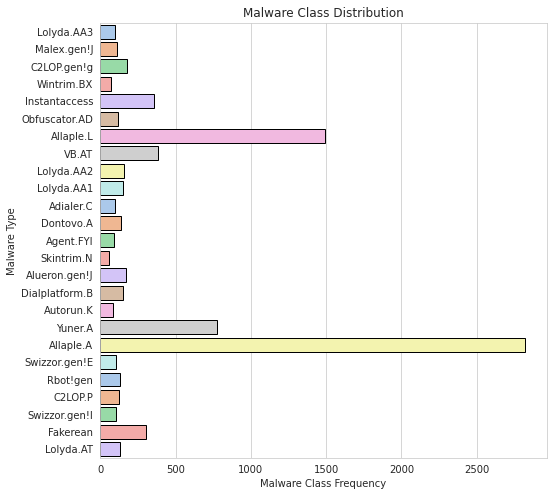

In [5]:
train_dataset.plot_class_distribution()

#### Malware Image Samples

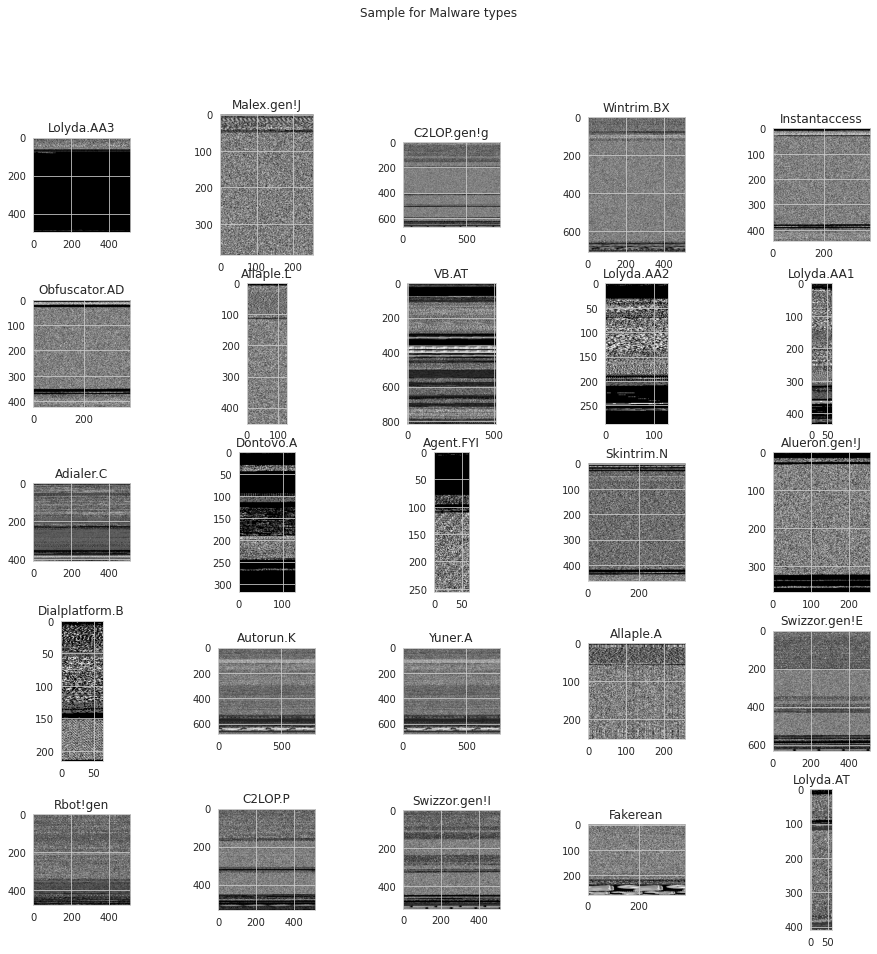

In [6]:
train_dataset.malware_samples()

## Malevis Image Dataset

#### Initialization of the dataset loader

In [7]:
train_dataset_malevis = MalwareImages(os.path.join("malevis", "test"),
                                      6)

#### Class Distribution

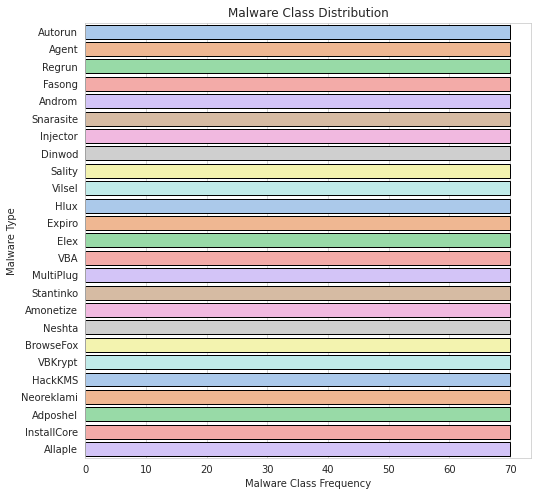

In [8]:
train_dataset_malevis.plot_class_distribution()

#### Malware Image Samples

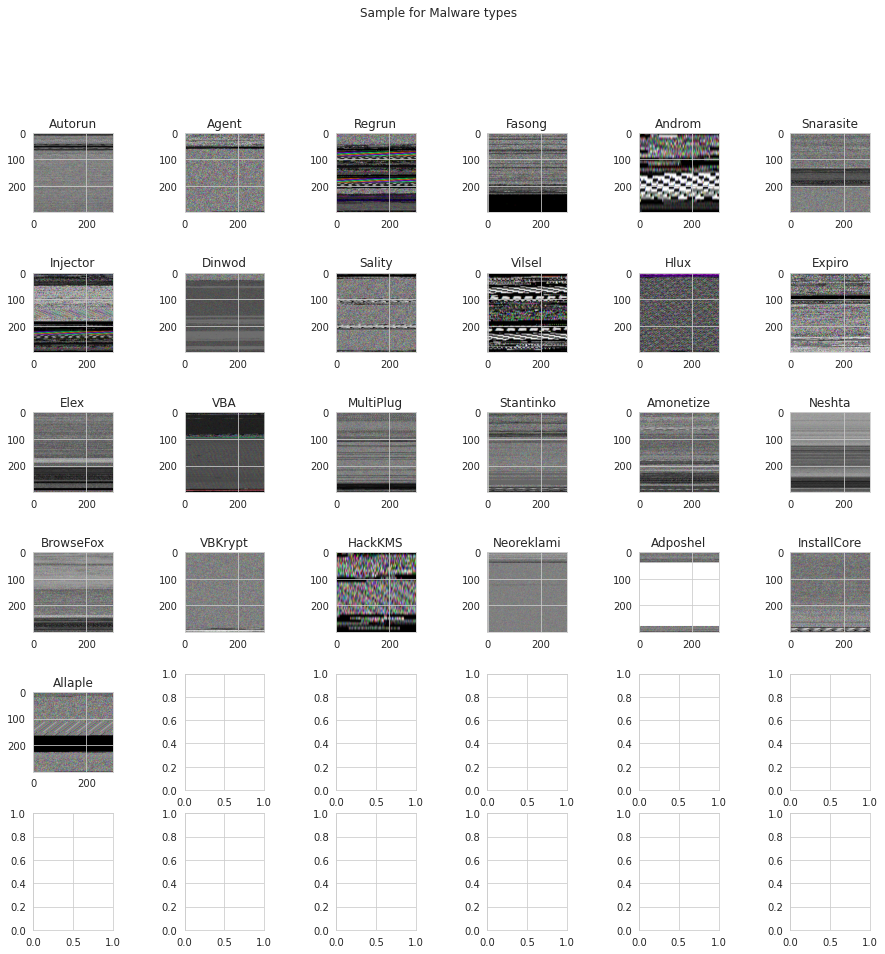

In [9]:
train_dataset_malevis.malware_samples()

## Blended Malware Dataset

#### Initialization of the data loader

In [10]:
train_data_blended = MalwareImages(os.path.join(blended_data_dir, "train"),
                                   6)

#### Class Distribution

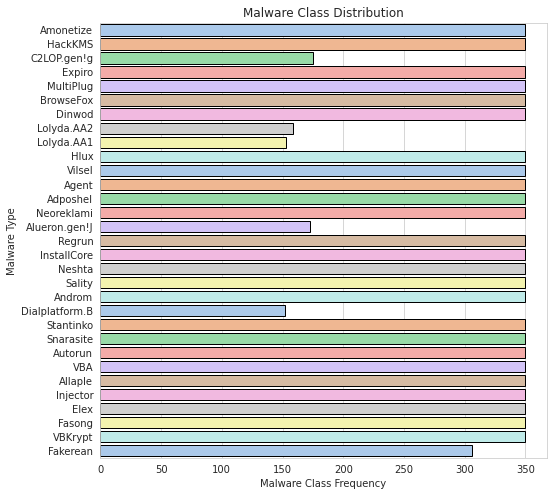

In [11]:
train_data_blended.plot_class_distribution()

#### Malware Image Samples

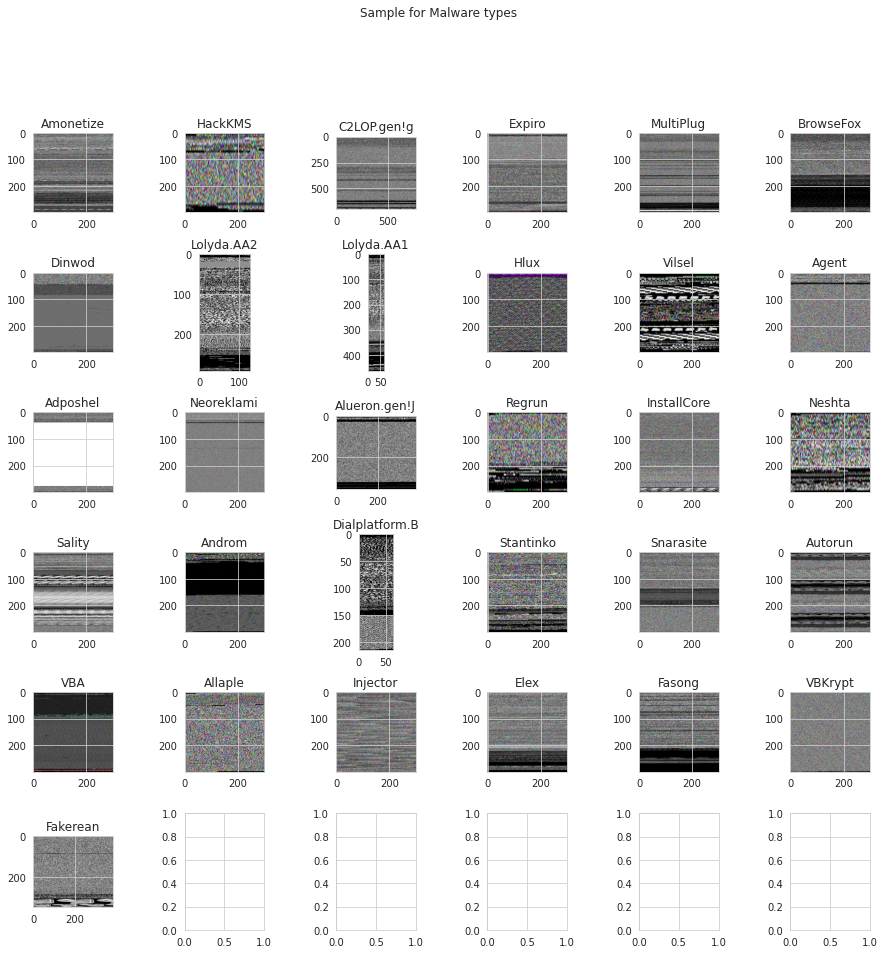

In [12]:
train_data_blended.malware_samples()

## Train-Test Split

In [13]:
# Splitting the dataset into training and testing subsets proportionally.
def split_dataset(train_data_dir : str, dest_path : str, train_ratio : float, test_ratio : float):

    splitfolders.ratio(input = train_data_dir, 
                       output = dest_path,
                       seed = 1337, 
                       ratio = (train_ratio, 0, test_ratio), 
                       group_prefix = None, 
                       move = False)

#### Malimg Dataset

In [ ]:
split_dataset(os.path.join(malimg_dir, 
                           "train"),
              "malimg/", 
              0.8, 
              0.2)

#### Malevis Dataset

In [ ]:
split_dataset(os.path.join(malevis_dir, 
                           "train"),
              "malevis/", 
              0.8, 
              0.2)

#### Blended Dataset

In [ ]:
split_dataset(os.path.join(blended_data_dir, 
                           "train"),
              "blended/", 
              0.8, 
              0.2)

# Image Preprocessing

In [14]:
# A class to preprocess the malware images to make it usable for training neural networks.
class ImageProcessor:
    
    # Initialization of the image preprecessor with required file locations.
    def __init__(self, model, train_dir : str, test_dir : str, val_dir : str, size, colormode : str) -> None:
        self.cnn_variant = model
        self.train_gen = None
        self.test_gen = None
        self.val_gen = None
        self.colormode = colormode
        self.TRAIN_DIR = train_dir
        self.TEST_DIR = test_dir
        self.VAL_DIR = val_dir
        self.size = size
    
    # Creating generators based on the preprocessing requirements of the CNN architecture.
    def create_generators(self):
        self.train_gen = tf.keras.preprocessing.image.ImageDataGenerator(
            preprocessing_function=self.cnn_variant.preprocess_input,
        )

        self.test_gen = tf.keras.preprocessing.image.ImageDataGenerator(
            preprocessing_function=self.cnn_variant.preprocess_input
        )

        self.val_gen =  tf.keras.preprocessing.image.ImageDataGenerator(
            preprocessing_function=self.cnn_variant.preprocess_input
        )
    
    # Reading the images from the respective directories.
    def get_images(self):
        train_images = self.train_gen.flow_from_directory(
            directory=self.TRAIN_DIR,
            target_size=self.size,
            color_mode=self.colormode,
            class_mode='categorical',
            batch_size=32,
            shuffle=True,
            seed=42,
            subset='training',
        )

        val_images = self.val_gen.flow_from_directory(
            directory=self.VAL_DIR,
            target_size=self.size,
            classes=sorted([i for i in os.listdir(self.TRAIN_DIR) if i != "Other"]),
            color_mode=self.colormode,
            class_mode='categorical',
            batch_size=32,
            shuffle=True,
            seed=42
        )

        test_images = self.test_gen.flow_from_directory(
            directory=self.TEST_DIR,
            target_size=self.size,
            color_mode=self.colormode,
            class_mode='categorical',
            batch_size=32,
            shuffle=False,
            seed=42
        )

        return train_images, val_images, test_images

# Domain Adaptation of CNN architectures

In [21]:
# A class to adapt the state of the art CNNs 
# for the classification of malware images.
class FineTuning:

    # Initialization of the Domain Adaptation process with required parameters.
    def __init__(self, train, val, model, class_count : int, regularize : bool, patience : int) -> None:
        self.train = train
        self.val = val
        self.model = model
        self.history = None
        self.fine_tune_from = 100
        self.CLASSES = class_count
        self.regularize = regularize
        self.patience = patience
    
    # Marking layers trainable or not.
    def fine_tune(self):
        for layer in self.model.layers[:self.fine_tune_from]:
            layer.trainable = False

        for layer in self.model.layers[self.fine_tune_from:]:
            layer.trainable = True
    
    # Addition of the final layer to the model with or without regularization.
    def add_final_layer(self):
        self.x = Flatten()(self.model.output)
        if self.regularize == True:
            self.x = Dense(2000, activation='relu')(self.x)
            self.x = Dropout(0.6)(self.x)
            self.x = Dense(1400, activation='relu')(self.x)
            self.x = Dropout(0.5)(self.x)
        self.x = Dense(1000, activation='relu')(self.x)
        self.predictions = Dense(self.CLASSES, activation = 'softmax')(self.x)
    
    # Compilation of the model with all the metrics, optimizer, and loss functions.
    def compile_model(self):
        self.model = Model(inputs = self.model.input, outputs = self.predictions)
        self.model.compile(optimizer='adam', loss="categorical_crossentropy", 
                           metrics=['accuracy',
                                    tf.keras.metrics.AUC(name="auc",from_logits=True),
                                    tf.keras.metrics.FalsePositives(name="false_positives"),
                                    tf.keras.metrics.Precision(name="precision"),
                                    tf.keras.metrics.Recall(name="recall")])
    
    # Training the model with Early Stopping Criterion
    # on Validation Loss.
    def train_model(self):
        self.history = self.model.fit(self.train,
                                      batch_size=32, 
                                      epochs=80, 
                                      validation_data=self.val,
                                      callbacks=[
                                        tf.keras.callbacks.EarlyStopping(
                                            monitor='val_loss',
                                            patience=self.patience,
                                            restore_best_weights=True
                                        )
                                     ])

# Experimentation of CNN architecture using Domain Adaptation

In [ ]:
# Experimentation of a CNN architecture on the datasets using Domain Adaptation.
def experiment_model(preprocess_fx, new_data_dir : str,orig_data_dir : str, size, model, nclasses : int, val_dir : str, regularize : bool, patience : int):
    # Preprocessing the images.
    img = ImageProcessor(preprocess_fx, 
                     os.path.join(new_data_dir, "train"),
                     os.path.join(new_data_dir, "test"),
                     os.path.join(orig_data_dir, val_dir),
                     size,
                     "rgb")
    img.create_generators()
    train, val, test = img.get_images()

    # Domain Adaptation of the CNN architecture.
    learner = FineTuning(train, val,
                         model, nclasses, 
                         regularize, patience)
    learner.fine_tune()
    learner.add_final_layer()
    learner.compile_model()
    learner.train_model()

    # Returning the model, its training history, and
    # preprocessed test data for model evaluation.
    return learner.model, learner.history, test

# Model Evaluation

In [22]:
# A class for the evaluating any Multiclass Classifier.
class ModelEvaluator:

    # Initialization of the evaluator with the model, 
    # its training history, and preprocessed test data.
    def __init__(self, history, classes : list, model, test):
        self.history = history
        self.model = model
        self.test = test
        self.classes = classes
        self.num_classes = len(self.classes)
        self.predictions = None
    
    # Plotting the comparison of the performance on train and validation data.
    # based on a particular metric.
    def __plot_metric(self, ax, metric: str,train_metric : str, val_metric : str):
        
        ax.plot(self.history.history[train_metric])
        ax.plot(self.history.history[val_metric])

        ax.title.set_text(train_metric + " v/s " + val_metric)
        ax.set_xlabel('Epochs')
        ax.set_ylabel(metric.title())
        ax.legend(['Train','Val'])
    
    # Plotting the overall training history.
    def training_history(self):
        rows = 3
        columns = 2
        c = 0
        metrics = ["loss", "accuracy", "auc", "false_positives", "precision", "recall"]

        fig, axs = plt.subplots(rows, columns,figsize=(15,15))
        for metric in metrics:
            self.__plot_metric(axs[c//columns, c%columns], 
                               metric.replace("_", " ").title(), 
                               metric, "val_"+metric)
            c += 1

        fig.suptitle("Training History of the Model")
        plt.subplots_adjust(bottom=0.1, top=0.9, hspace=0.5)
        plt.show()
    
    # Fetching the predictions from the model and its post processing.
    def predict(self):
        self.predictions = self.model.predict(self.test)
        self.predictions = list(map(np.argmax, self.predictions))
    
    # Displaying the classification report and Confusion Matrix.
    def class_report(self):
        plt.figure(figsize=(15,15))
        sns.heatmap(tf.math.confusion_matrix(self.test.labels, self.predictions, num_classes=len(self.classes)), 
                    annot=True, cmap="crest")
                    
        print(classification_report(self.test.labels, self.predictions, target_names=self.classes))

# Model Exploration on the three datasets

In [23]:
malimg_models = dict()
malevis_models = dict()
blended_models = dict()

## XceptionNet

### Malimg Dataset

#### Model Training

In [24]:
model, history, test = experiment_model(cnns.xception,
                                        "malimg",
                                        malimg_dir, 
                                        (75, 75),
                                        cnns.Xception(include_top=False, 
                                                      input_shape=(75, 75, 3)), 
                                        25, "validation", 
                                        False, 3)

83697664/83683744 [==============================] - 1s 0us/step
Found 6711 images belonging to 25 classes.
Found 910 images belonging to 25 classes.
Found 1693 images belonging to 25 classes.
Epoch 1/80
210/210 [==============================] - 22s 87ms/step - loss: 1.2815 - accuracy: 0.6173 - auc: 0.9602 - false_positives: 1250.0000 - precision: 0.7341 - recall: 0.5142 - val_loss: 0.7678 - val_accuracy: 0.7176 - val_auc: 0.9866 - val_false_positives: 192.0000 - val_precision: 0.7621 - val_recall: 0.6758
Epoch 2/80
210/210 [==============================] - 17s 79ms/step - loss: 0.5599 - accuracy: 0.8157 - auc: 0.9877 - false_positives: 922.0000 - precision: 0.8492 - recall: 0.7738 - val_loss: 0.7335 - val_accuracy: 0.8088 - val_auc: 0.9725 - val_false_positives: 122.0000 - val_precision: 0.8527 - val_recall: 0.7758
Epoch 3/80
210/210 [==============================] - 17s 79ms/step - loss: 0.3344 - accuracy: 0.8787 - auc: 0.9946 - false_positives: 662.0000 - precision: 0.8974 - reca

#### Model Evaluation

##### Initialization of evaluator

In [25]:
me = ModelEvaluator(history, 
                    list(test.class_indices.keys()), 
                    model, test)

##### Training History

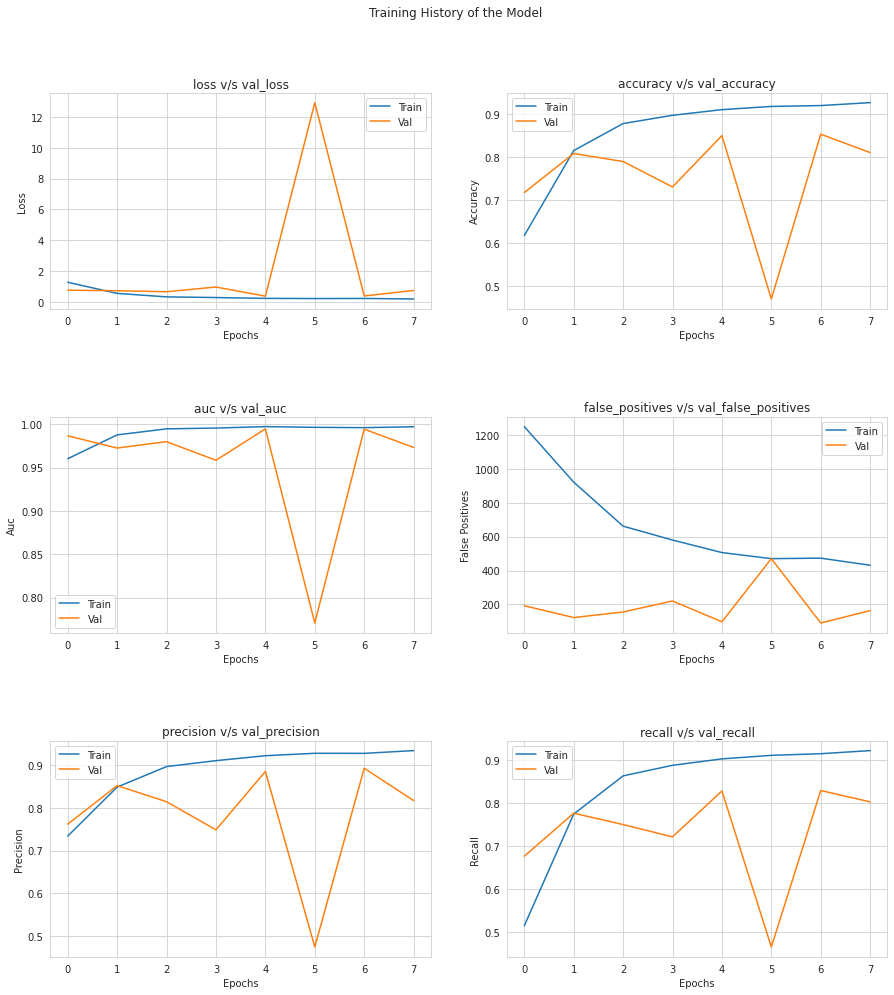

In [26]:
me.training_history()

##### Classification Metrics

/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


                precision    recall  f1-score   support

     Adialer.C       1.00      1.00      1.00        20
     Agent.FYI       1.00      1.00      1.00        19
     Allaple.A       0.81      0.95      0.87       565
     Allaple.L       0.97      0.57      0.71       299
 Alueron.gen!J       1.00      0.97      0.99        35
     Autorun.K       0.00      0.00      0.00        17
       C2LOP.P       0.82      0.56      0.67        25
   C2LOP.gen!g       0.58      0.97      0.72        35
Dialplatform.B       1.00      0.97      0.98        31
     Dontovo.A       1.00      1.00      1.00        28
      Fakerean       1.00      1.00      1.00        62
 Instantaccess       0.97      1.00      0.99        72
    Lolyda.AA1       0.93      0.87      0.90        31
    Lolyda.AA2       1.00      0.94      0.97        32
    Lolyda.AA3       1.00      1.00      1.00        20
     Lolyda.AT       0.96      1.00      0.98        27
   Malex.gen!J       0.53      0.74      0.62  

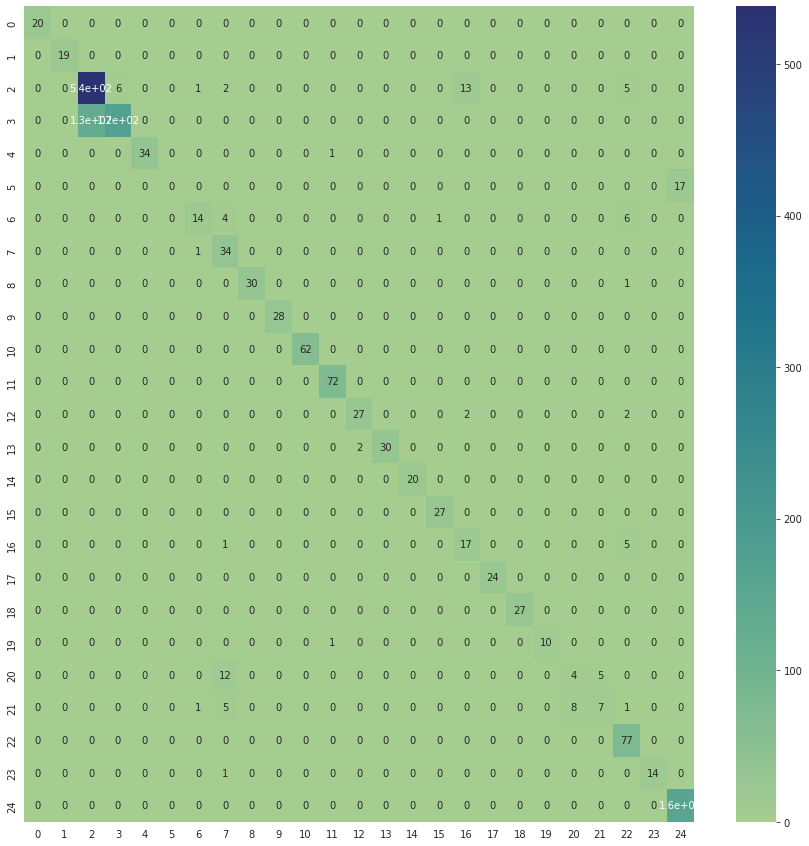

In [27]:
me.predict()
me.class_report()

#### Saving essential data

In [28]:
malimg_models["XceptionNet"] = {"Ground Truth": test.labels.tolist(), 
                                "Predictions":np.array(me.predictions).tolist(), 
                                "History": history.history}

### Malevis Dataset

### Model training

In [29]:
model, history, test = experiment_model(cnns.xception,
                                        "malevis",malevis_dir, 
                                        (200, 200),
                                        cnns.Xception(include_top=False, 
                                                      input_shape=(200, 200, 3)), 
                                        25, "val", 
                                        False, 8)

Found 7000 images belonging to 25 classes.
Found 3644 images belonging to 25 classes.
Found 1750 images belonging to 25 classes.
Epoch 1/80
219/219 [==============================] - 74s 323ms/step - loss: 1.3728 - accuracy: 0.6647 - auc: 0.9463 - false_positives: 480.0000 - precision: 0.8953 - recall: 0.5866 - val_loss: 0.6968 - val_accuracy: 0.8312 - val_auc: 0.9739 - val_false_positives: 318.0000 - val_precision: 0.9034 - val_recall: 0.8164
Epoch 2/80
219/219 [==============================] - 58s 265ms/step - loss: 0.6023 - accuracy: 0.8566 - auc: 0.9850 - false_positives: 458.0000 - precision: 0.9256 - recall: 0.8141 - val_loss: 0.6194 - val_accuracy: 0.8521 - val_auc: 0.9719 - val_false_positives: 352.0000 - val_precision: 0.8965 - val_recall: 0.8364
Epoch 3/80
219/219 [==============================] - 47s 214ms/step - loss: 0.3684 - accuracy: 0.8997 - auc: 0.9914 - false_positives: 334.0000 - precision: 0.9480 - recall: 0.8694 - val_loss: 0.2924 - val_accuracy: 0.9212 - val_auc

### Model Evaluation

##### Initialization of Evaluator

In [30]:
me = ModelEvaluator(history, 
                    list(test.class_indices.keys()), 
                    model, test)

##### Training History

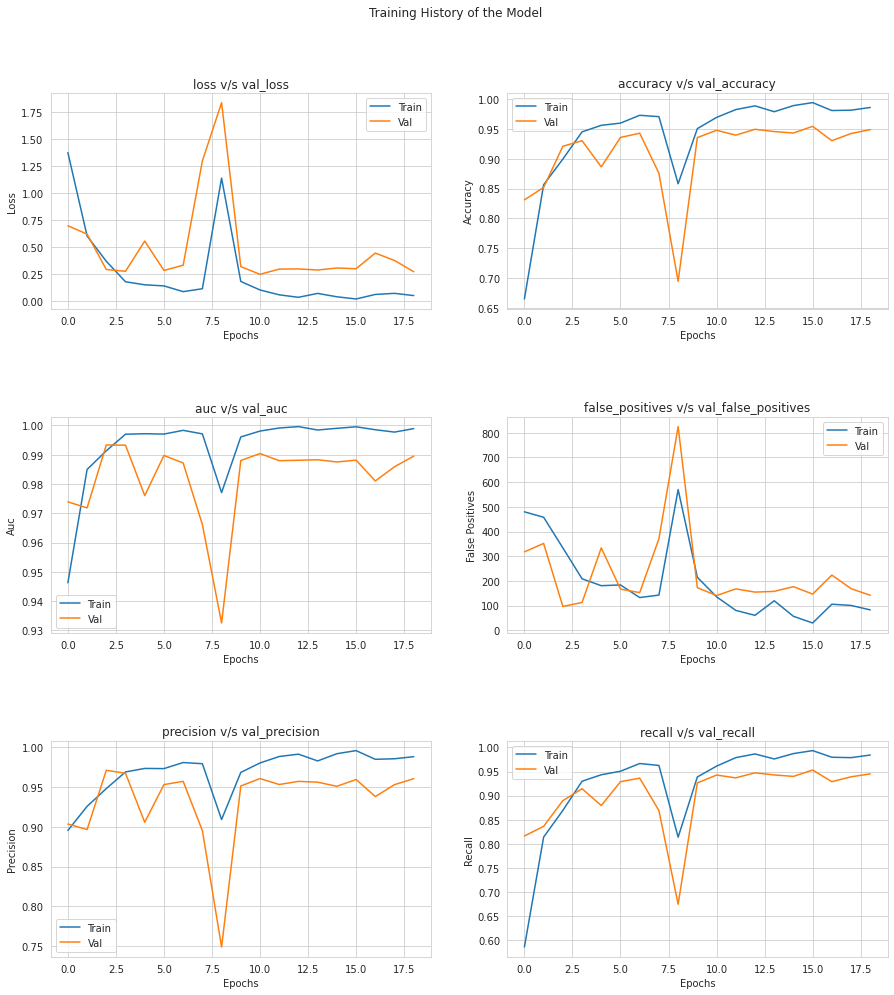

In [31]:
me.training_history()

##### Classification Metrics

              precision    recall  f1-score   support

    Adposhel       1.00      1.00      1.00        70
       Agent       0.84      0.83      0.83        70
     Allaple       0.86      1.00      0.93        70
   Amonetize       1.00      0.96      0.98        70
      Androm       0.91      0.87      0.89        70
     Autorun       0.91      0.87      0.89        70
   BrowseFox       0.96      0.99      0.97        70
      Dinwod       1.00      1.00      1.00        70
        Elex       0.99      1.00      0.99        70
      Expiro       0.87      0.87      0.87        70
      Fasong       1.00      1.00      1.00        70
     HackKMS       0.99      1.00      0.99        70
        Hlux       1.00      1.00      1.00        70
    Injector       0.94      0.87      0.90        70
 InstallCore       0.99      0.97      0.98        70
   MultiPlug       0.99      0.99      0.99        70
  Neoreklami       1.00      1.00      1.00        70
      Neshta       0.74    

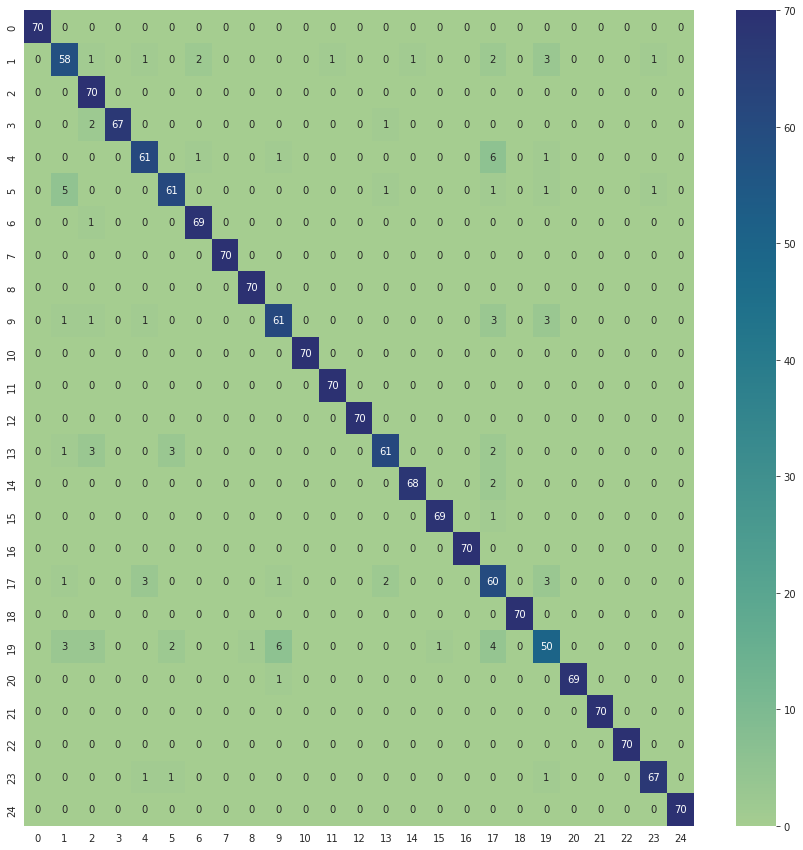

In [32]:
me.predict()
me.class_report()

#### Saving Essential data

In [33]:
malevis_models["XceptionNet"] = {"Ground Truth": test.labels.tolist(), 
                                 "Predictions":np.array(me.predictions).tolist(), 
                                 "History": history.history}

### Blended Dataset

#### Model Training

In [34]:
model, history, test = experiment_model(cnns.xception,
                                        "blended",blended_data_dir, 
                                        (75, 75),
                                        cnns.Xception(include_top=False, 
                                                      input_shape=(75, 75, 3)), 
                                        31, "val", 
                                        False, 5)

Found 7892 images belonging to 31 classes.
Found 3879 images belonging to 31 classes.
Found 1976 images belonging to 31 classes.
Epoch 1/80
247/247 [==============================] - 65s 251ms/step - loss: 1.9887 - accuracy: 0.4610 - auc: 0.8953 - false_positives: 469.0000 - precision: 0.8545 - recall: 0.3490 - val_loss: 1.1123 - val_accuracy: 0.6808 - val_auc: 0.9579 - val_false_positives: 293.0000 - val_precision: 0.8896 - val_recall: 0.6084
Epoch 2/80
247/247 [==============================] - 38s 155ms/step - loss: 0.5847 - accuracy: 0.8348 - auc: 0.9859 - false_positives: 513.0000 - precision: 0.9228 - recall: 0.7775 - val_loss: 0.5479 - val_accuracy: 0.8427 - val_auc: 0.9874 - val_false_positives: 218.0000 - val_precision: 0.9335 - val_recall: 0.7894
Epoch 3/80
247/247 [==============================] - 37s 151ms/step - loss: 0.3892 - accuracy: 0.8886 - auc: 0.9913 - false_positives: 393.0000 - precision: 0.9449 - recall: 0.8534 - val_loss: 0.9598 - val_accuracy: 0.8139 - val_auc

### Model Evaluation

##### Initialization of the Evaluator

In [35]:
me = ModelEvaluator(history, list(test.class_indices.keys()), model, test)

##### Training History

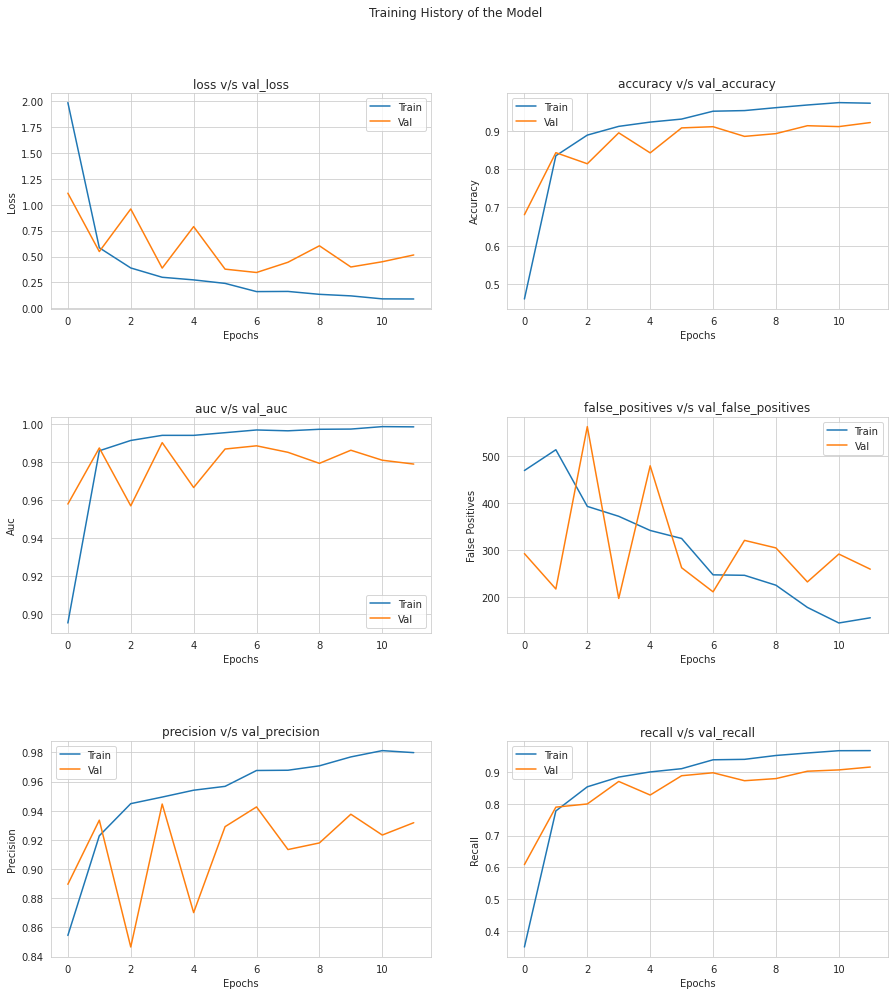

In [36]:
me.training_history()

##### Classification Metrics

                precision    recall  f1-score   support

      Adposhel       1.00      1.00      1.00        70
         Agent       0.81      0.80      0.81        70
       Allaple       0.90      0.94      0.92        70
 Alueron.gen!J       1.00      1.00      1.00        35
     Amonetize       0.70      0.96      0.81        70
        Androm       0.77      0.81      0.79        70
       Autorun       0.78      0.96      0.86        70
     BrowseFox       0.97      0.96      0.96        70
   C2LOP.gen!g       1.00      1.00      1.00        35
Dialplatform.B       1.00      1.00      1.00        31
        Dinwod       0.96      1.00      0.98        70
          Elex       0.97      0.96      0.96        70
        Expiro       0.81      0.81      0.81        70
      Fakerean       1.00      1.00      1.00        62
        Fasong       1.00      1.00      1.00        70
       HackKMS       1.00      1.00      1.00        70
          Hlux       1.00      1.00      1.00  

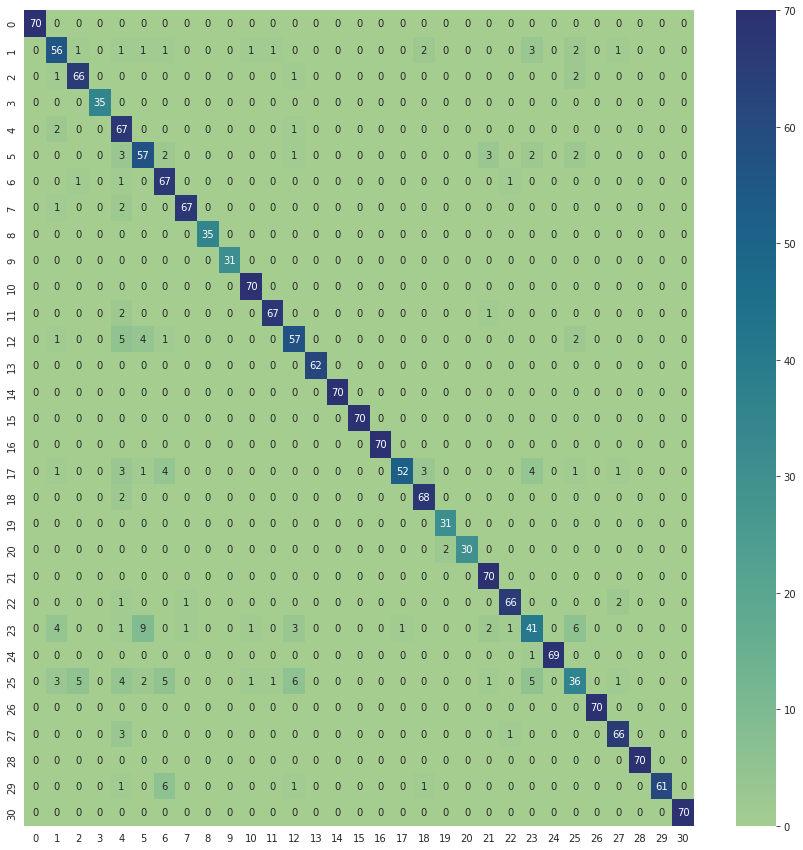

In [37]:
me.predict()
me.class_report()

#### Saving essential data

In [38]:
blended_models["XceptionNet"] = {"Ground Truth": test.labels.tolist(), 
                                 "Predictions":np.array(me.predictions).tolist(), 
                                 "History": history.history}

## EfficientNetB0

### Malimg Dataset

#### Model Training 

In [39]:
model, history, test = experiment_model(cnns.efficientnet,
                                        "malimg",malimg_dir, 
                                        (75, 75),
                                        cnns.EfficientNetB0(include_top=False, 
                                                            input_shape=(75, 75, 3)), 
                                        25, "validation", 
                                        False, 3)

16719872/16705208 [==============================] - 0s 0us/step
Found 6711 images belonging to 25 classes.
Found 910 images belonging to 25 classes.
Found 1693 images belonging to 25 classes.
Epoch 1/80
210/210 [==============================] - 35s 130ms/step - loss: 0.6007 - accuracy: 0.8301 - auc: 0.9810 - false_positives: 929.0000 - precision: 0.8550 - recall: 0.8163 - val_loss: 0.2621 - val_accuracy: 0.9209 - val_auc: 0.9929 - val_false_positives: 62.0000 - val_precision: 0.9305 - val_recall: 0.9121
Epoch 2/80
210/210 [==============================] - 18s 84ms/step - loss: 0.2329 - accuracy: 0.9297 - auc: 0.9948 - false_positives: 409.0000 - precision: 0.9380 - recall: 0.9219 - val_loss: 0.4676 - val_accuracy: 0.9000 - val_auc: 0.9831 - val_false_positives: 77.0000 - val_precision: 0.9135 - val_recall: 0.8934
Epoch 3/80
210/210 [==============================] - 22s 104ms/step - loss: 0.2134 - accuracy: 0.9394 - auc: 0.9952 - false_positives: 362.0000 - precision: 0.9454 - recal

#### Model Evaluation

##### Initialization of the Evaluator

In [40]:
me = ModelEvaluator(history, 
                    list(test.class_indices.keys()), 
                    model, test)

##### Training History

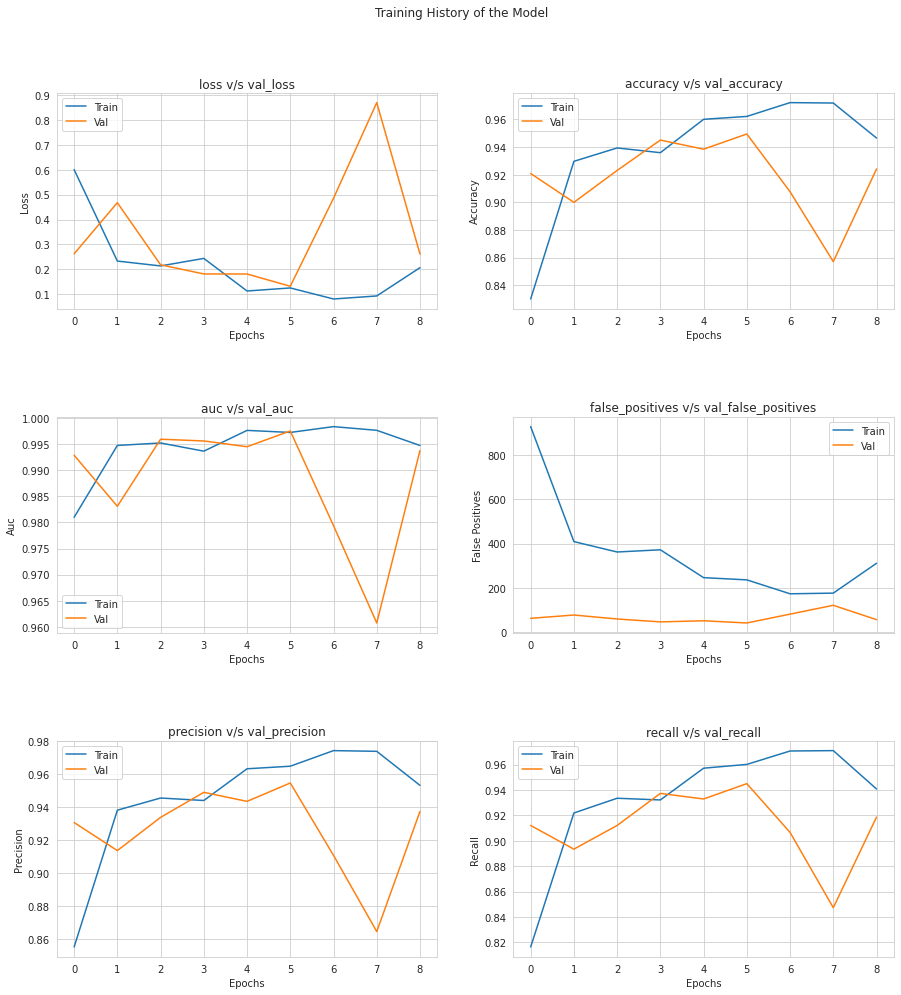

In [41]:
me.training_history()

##### Classification Metrics

                precision    recall  f1-score   support

     Adialer.C       1.00      1.00      1.00        20
     Agent.FYI       1.00      1.00      1.00        19
     Allaple.A       0.99      0.96      0.98       565
     Allaple.L       0.96      1.00      0.98       299
 Alueron.gen!J       0.95      1.00      0.97        35
     Autorun.K       1.00      1.00      1.00        17
       C2LOP.P       0.78      0.84      0.81        25
   C2LOP.gen!g       0.84      0.77      0.81        35
Dialplatform.B       1.00      1.00      1.00        31
     Dontovo.A       1.00      1.00      1.00        28
      Fakerean       0.91      1.00      0.95        62
 Instantaccess       1.00      1.00      1.00        72
    Lolyda.AA1       0.94      0.94      0.94        31
    Lolyda.AA2       1.00      0.94      0.97        32
    Lolyda.AA3       1.00      1.00      1.00        20
     Lolyda.AT       0.96      0.96      0.96        27
   Malex.gen!J       0.87      0.87      0.87  

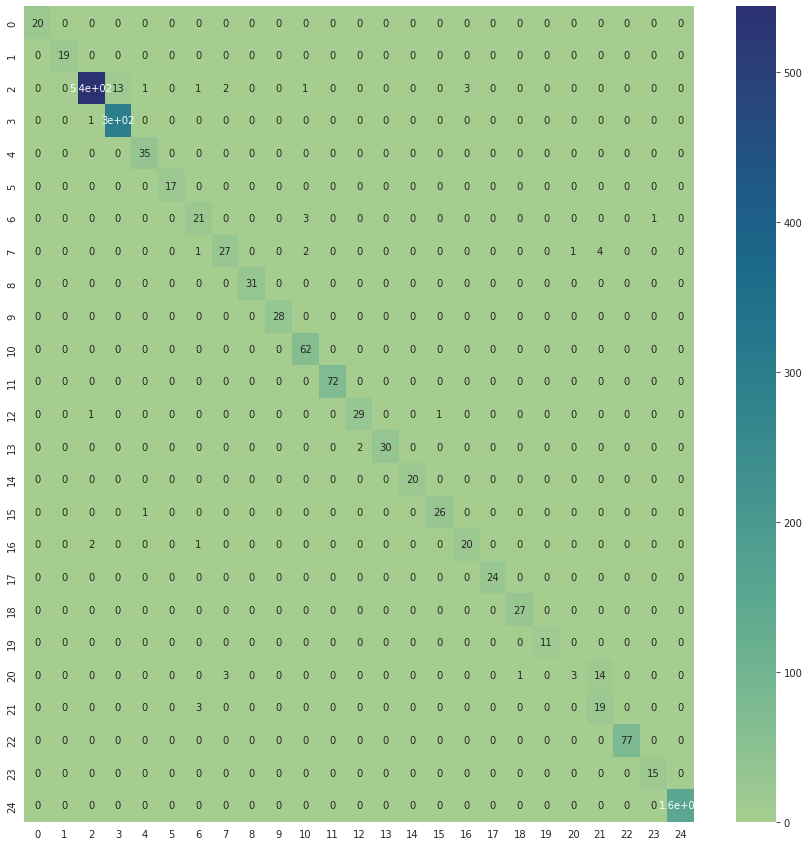

In [42]:
me.predict()
me.class_report()

#### Saving essential data

In [43]:
malimg_models["EfficientNetB0"] = {"Ground Truth": test.labels.tolist(), 
                                   "Predictions":np.array(me.predictions).tolist(), 
                                   "History": history.history}

### Malevis Dataset

#### Model Training

In [44]:
model, history, test = experiment_model(cnns.efficientnet,
                                        "malevis",malevis_dir, 
                                        (200,200),
                                        cnns.EfficientNetB0(include_top=False, 
                                                            input_shape=(200, 200, 3)), 
                                        25, "val", 
                                        False, 8)

Found 7000 images belonging to 25 classes.
Found 3644 images belonging to 25 classes.
Found 1750 images belonging to 25 classes.
Epoch 1/80
219/219 [==============================] - 62s 251ms/step - loss: 0.7657 - accuracy: 0.8640 - auc: 0.9716 - false_positives: 607.0000 - precision: 0.9069 - recall: 0.8446 - val_loss: 0.4295 - val_accuracy: 0.9086 - val_auc: 0.9831 - val_false_positives: 202.0000 - val_precision: 0.9416 - val_recall: 0.8943
Epoch 2/80
219/219 [==============================] - 45s 203ms/step - loss: 0.2479 - accuracy: 0.9423 - auc: 0.9919 - false_positives: 279.0000 - precision: 0.9591 - recall: 0.9337 - val_loss: 0.5017 - val_accuracy: 0.9311 - val_auc: 0.9815 - val_false_positives: 229.0000 - val_precision: 0.9366 - val_recall: 0.9286
Epoch 3/80
219/219 [==============================] - 43s 197ms/step - loss: 0.4268 - accuracy: 0.9113 - auc: 0.9856 - false_positives: 426.0000 - precision: 0.9367 - recall: 0.9004 - val_loss: 0.4788 - val_accuracy: 0.9034 - val_auc

#### Model Evaluation

##### Initialization of the Evaluator

In [45]:
me = ModelEvaluator(history, 
                    list(test.class_indices.keys()), 
                    model, test)

##### Training History

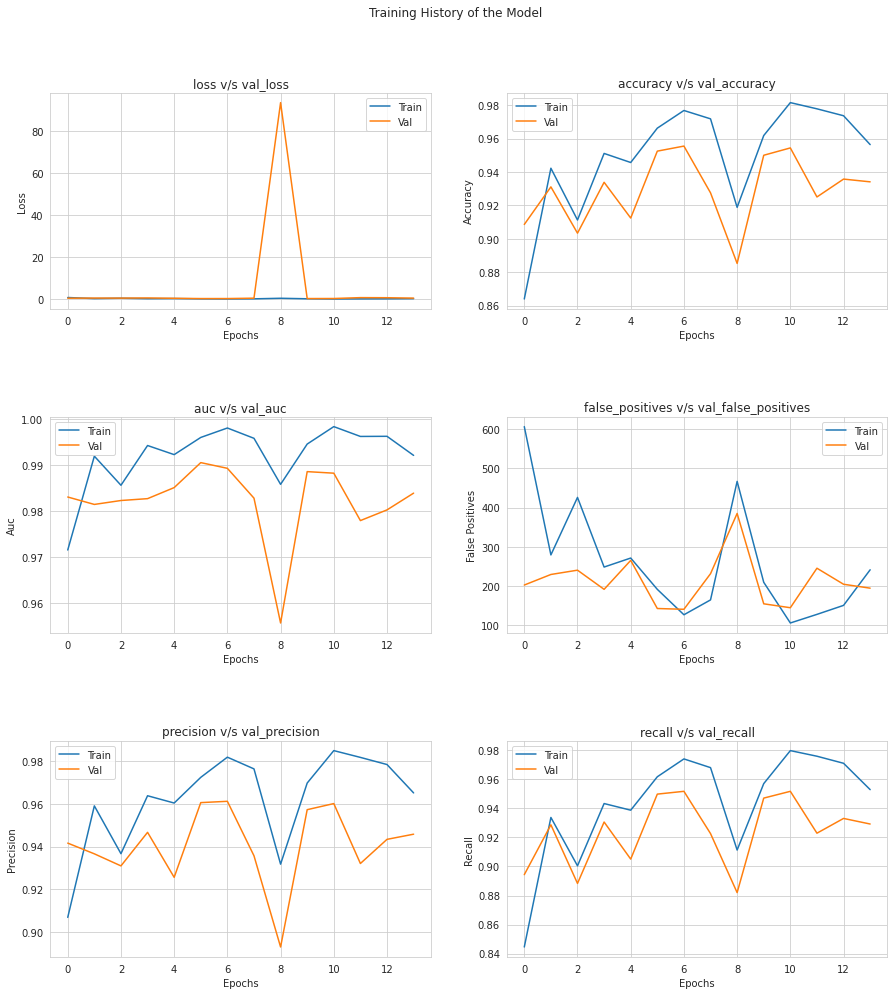

In [46]:
me.training_history()

##### Classification Metrics

              precision    recall  f1-score   support

    Adposhel       1.00      1.00      1.00        70
       Agent       0.86      0.86      0.86        70
     Allaple       0.97      0.96      0.96        70
   Amonetize       1.00      0.94      0.97        70
      Androm       0.89      0.90      0.89        70
     Autorun       0.90      0.87      0.88        70
   BrowseFox       0.97      0.99      0.98        70
      Dinwod       1.00      1.00      1.00        70
        Elex       0.90      1.00      0.95        70
      Expiro       0.77      0.96      0.85        70
      Fasong       1.00      1.00      1.00        70
     HackKMS       1.00      1.00      1.00        70
        Hlux       1.00      1.00      1.00        70
    Injector       0.92      0.81      0.86        70
 InstallCore       0.97      0.99      0.98        70
   MultiPlug       0.94      0.96      0.95        70
  Neoreklami       0.94      0.97      0.96        70
      Neshta       0.86    

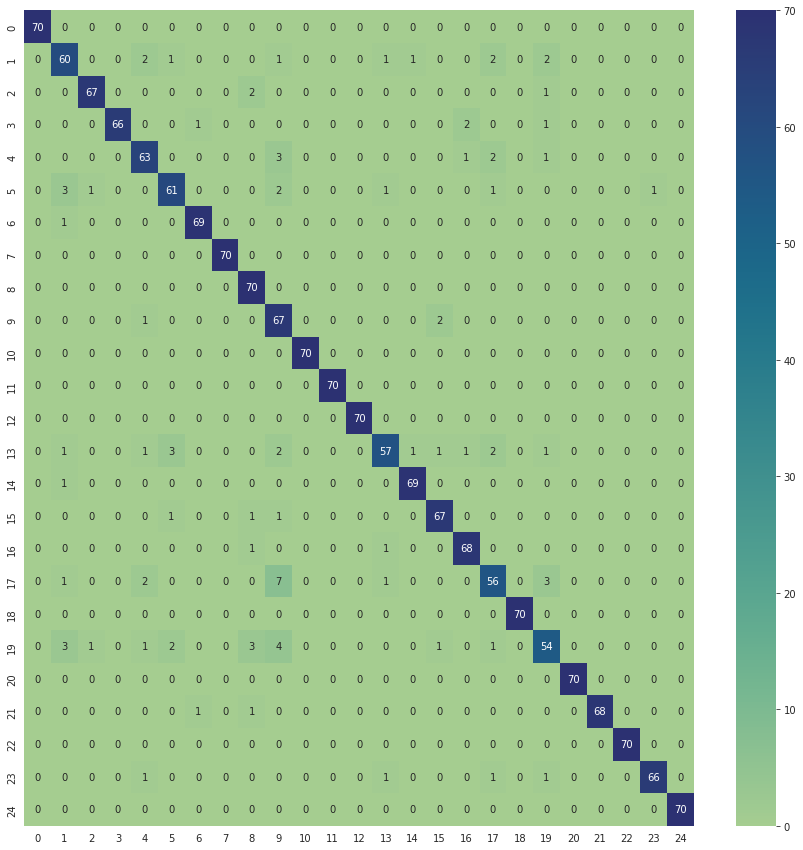

In [47]:
me.predict()
me.class_report()

#### Saving essential data

In [48]:
malevis_models["EfficientNetB0"] = {"Ground Truth": test.labels.tolist(), 
                                    "Predictions":np.array(me.predictions).tolist(), 
                                    "History": history.history}

### Blended Dataset

#### Model Training

In [49]:
model, history, test = experiment_model(cnns.efficientnet,
                                        "blended",blended_data_dir, 
                                        (75, 75),
                                        cnns.EfficientNetB0(include_top=False, 
                                                            input_shape=(75, 75, 3)), 
                                        31, "val", 
                                        False, 5)

Found 7892 images belonging to 31 classes.
Found 3879 images belonging to 31 classes.
Found 1976 images belonging to 31 classes.
Epoch 1/80
247/247 [==============================] - 51s 178ms/step - loss: 0.7390 - accuracy: 0.8260 - auc: 0.9718 - false_positives: 695.0000 - precision: 0.8993 - recall: 0.7865 - val_loss: 0.3032 - val_accuracy: 0.9162 - val_auc: 0.9907 - val_false_positives: 153.0000 - val_precision: 0.9580 - val_recall: 0.8995
Epoch 2/80
247/247 [==============================] - 43s 173ms/step - loss: 0.3134 - accuracy: 0.9162 - auc: 0.9912 - false_positives: 369.0000 - precision: 0.9505 - recall: 0.8979 - val_loss: 0.3018 - val_accuracy: 0.9234 - val_auc: 0.9911 - val_false_positives: 155.0000 - val_precision: 0.9579 - val_recall: 0.9082
Epoch 3/80
247/247 [==============================] - 38s 155ms/step - loss: 0.3279 - accuracy: 0.9169 - auc: 0.9917 - false_positives: 425.0000 - precision: 0.9437 - recall: 0.9021 - val_loss: 0.5185 - val_accuracy: 0.8992 - val_auc

#### Model Evaluation

##### Initialization of the evaluator

In [50]:
me = ModelEvaluator(history, 
                    list(test.class_indices.keys()), 
                    model, test)

##### Training History

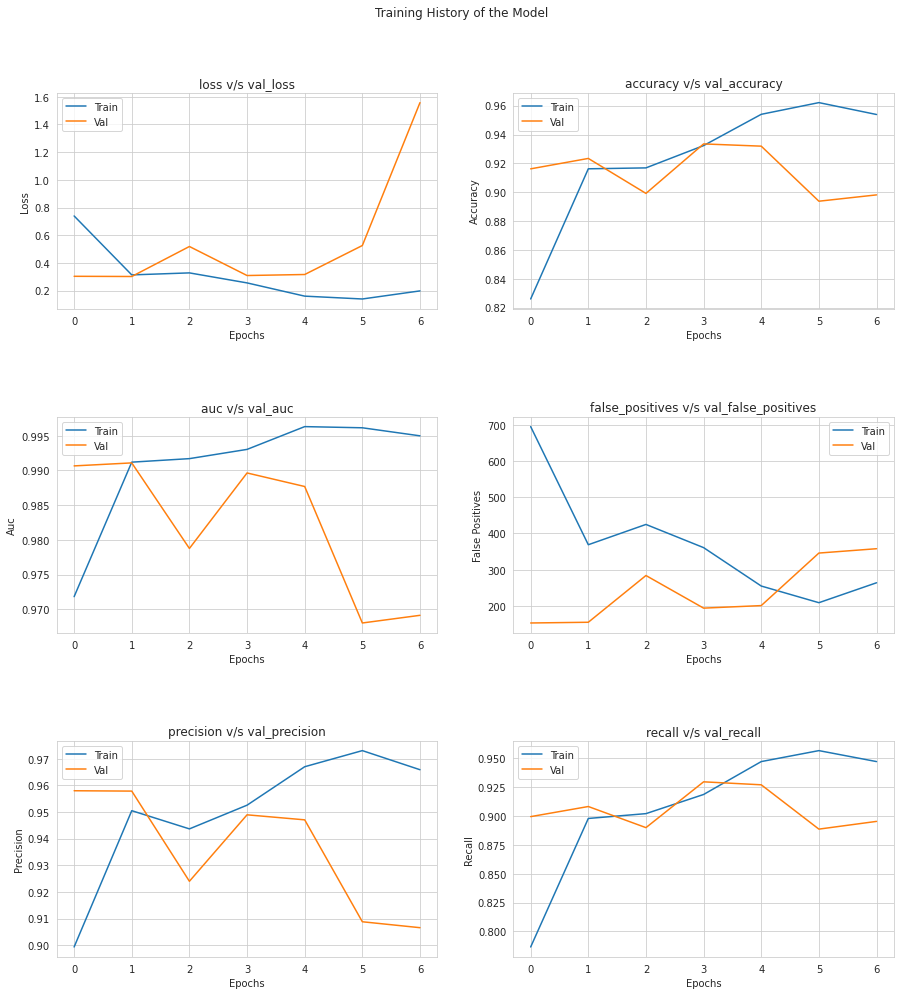

In [51]:
me.training_history()

##### Classification Metrics

                precision    recall  f1-score   support

      Adposhel       0.96      1.00      0.98        70
         Agent       0.88      0.73      0.80        70
       Allaple       0.93      0.94      0.94        70
 Alueron.gen!J       1.00      1.00      1.00        35
     Amonetize       0.96      0.94      0.95        70
        Androm       0.92      0.66      0.77        70
       Autorun       0.85      0.83      0.84        70
     BrowseFox       0.99      0.99      0.99        70
   C2LOP.gen!g       1.00      1.00      1.00        35
Dialplatform.B       1.00      1.00      1.00        31
        Dinwod       0.99      0.94      0.96        70
          Elex       0.93      1.00      0.97        70
        Expiro       0.74      0.91      0.82        70
      Fakerean       0.98      1.00      0.99        62
        Fasong       1.00      1.00      1.00        70
       HackKMS       1.00      0.99      0.99        70
          Hlux       0.90      1.00      0.95  

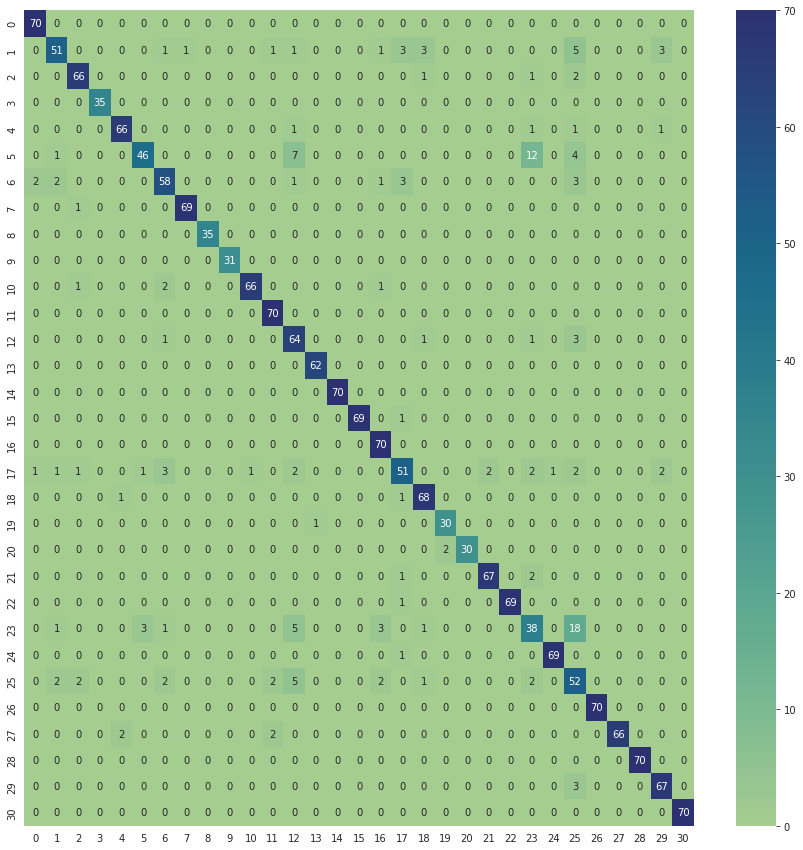

In [52]:
me.predict()
me.class_report()

#### Saving essential data

In [53]:
blended_models["EfficientNetB0"] = {"Ground Truth": test.labels.tolist(), 
                                    "Predictions":np.array(me.predictions).tolist(), 
                                    "History": history.history}

## ResNet50

### Malimg Dataset

#### Model Training

In [54]:
model, history, test = experiment_model(cnns.resnet,
                                        "malimg",malimg_dir,
                                        (75,75),
                                        cnns.ResNet50(include_top=False, 
                                                      input_shape=(75, 75, 3)), 
                                        25, "validation", 
                                        False, 3)

Found 6711 images belonging to 25 classes.
Found 910 images belonging to 25 classes.
Found 1693 images belonging to 25 classes.
Epoch 1/80
210/210 [==============================] - 26s 96ms/step - loss: 1.0854 - accuracy: 0.8003 - auc: 0.9798 - false_positives: 1065.0000 - precision: 0.8302 - recall: 0.7759 - val_loss: 0.2749 - val_accuracy: 0.8956 - val_auc: 0.9959 - val_false_positives: 65.0000 - val_precision: 0.9256 - val_recall: 0.8890
Epoch 2/80
210/210 [==============================] - 19s 88ms/step - loss: 0.2331 - accuracy: 0.9242 - auc: 0.9953 - false_positives: 440.0000 - precision: 0.9334 - recall: 0.9183 - val_loss: 0.2475 - val_accuracy: 0.9055 - val_auc: 0.9957 - val_false_positives: 59.0000 - val_precision: 0.9327 - val_recall: 0.8989
Epoch 3/80
210/210 [==============================] - 19s 90ms/step - loss: 0.1223 - accuracy: 0.9526 - auc: 0.9983 - false_positives: 306.0000 - precision: 0.9542 - recall: 0.9498 - val_loss: 0.2732 - val_accuracy: 0.9176 - val_auc: 0.9

#### Model Evaluation

##### Initialization of the evaluator

In [55]:
me = ModelEvaluator(history, list(test.class_indices.keys()), model, test)

##### Training History

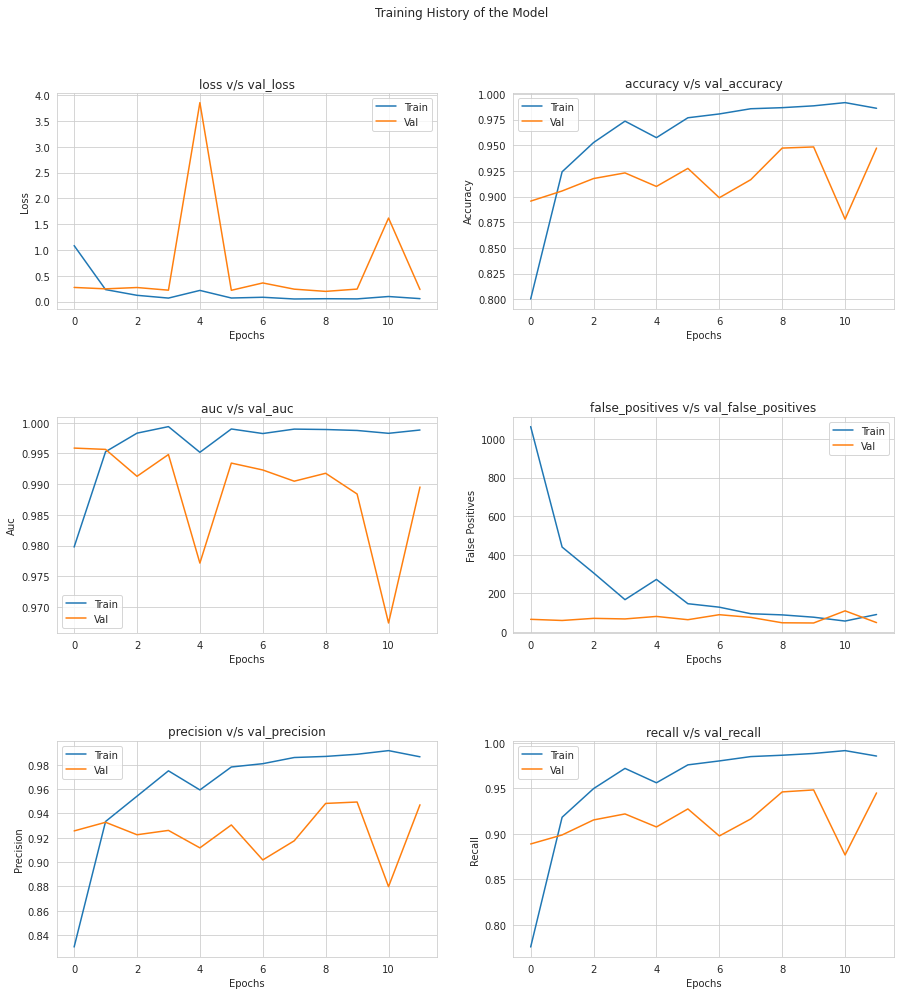

In [56]:
me.training_history()

##### Classification Metrics

                precision    recall  f1-score   support

     Adialer.C       1.00      1.00      1.00        20
     Agent.FYI       1.00      1.00      1.00        19
     Allaple.A       0.99      0.93      0.96       565
     Allaple.L       0.89      0.98      0.93       299
 Alueron.gen!J       1.00      1.00      1.00        35
     Autorun.K       1.00      1.00      1.00        17
       C2LOP.P       0.77      0.80      0.78        25
   C2LOP.gen!g       0.87      0.74      0.80        35
Dialplatform.B       1.00      0.97      0.98        31
     Dontovo.A       1.00      1.00      1.00        28
      Fakerean       1.00      1.00      1.00        62
 Instantaccess       1.00      1.00      1.00        72
    Lolyda.AA1       0.89      1.00      0.94        31
    Lolyda.AA2       1.00      0.94      0.97        32
    Lolyda.AA3       1.00      1.00      1.00        20
     Lolyda.AT       1.00      1.00      1.00        27
   Malex.gen!J       0.88      0.96      0.92  

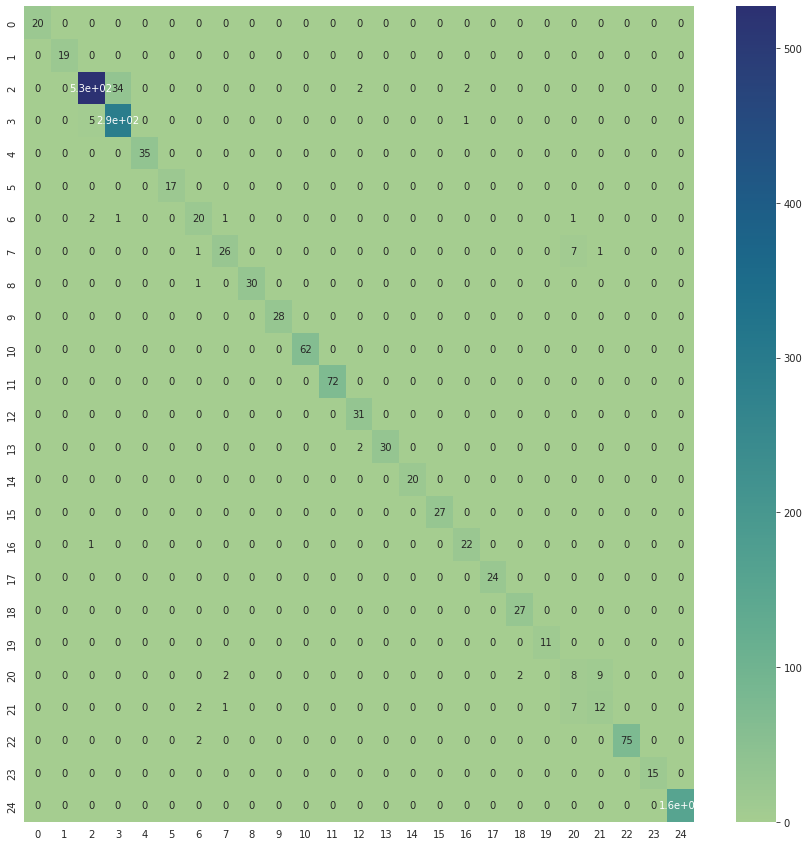

In [57]:
me.predict()
me.class_report()

#### Saving essential data

In [58]:
malimg_models["ResNet50"] = {"Ground Truth": test.labels.tolist(), 
                             "Predictions":np.array(me.predictions).tolist(), 
                             "History": history.history}

### Malevis Dataset

#### Model Training

In [59]:
model, history, test = experiment_model(cnns.resnet,
                                        "malevis",malevis_dir, 
                                        (200,200),
                                        cnns.ResNet50(include_top=False, 
                                                      input_shape=(200, 200, 3)), 
                                        25, "val", 
                                        False, 8)

Found 7000 images belonging to 25 classes.
Found 3644 images belonging to 25 classes.
Found 1750 images belonging to 25 classes.
Epoch 1/80
219/219 [==============================] - 61s 258ms/step - loss: 2.7481 - accuracy: 0.8359 - auc: 0.9669 - false_positives: 532.0000 - precision: 0.9118 - recall: 0.7860 - val_loss: 21.4871 - val_accuracy: 0.7387 - val_auc: 0.8940 - val_false_positives: 823.0000 - val_precision: 0.7618 - val_recall: 0.7223
Epoch 2/80
219/219 [==============================] - 50s 230ms/step - loss: 0.6688 - accuracy: 0.9286 - auc: 0.9894 - false_positives: 326.0000 - precision: 0.9516 - recall: 0.9154 - val_loss: 0.8883 - val_accuracy: 0.9317 - val_auc: 0.9865 - val_false_positives: 175.0000 - val_precision: 0.9505 - val_recall: 0.9226
Epoch 3/80
219/219 [==============================] - 50s 230ms/step - loss: 0.4482 - accuracy: 0.9611 - auc: 0.9952 - false_positives: 202.0000 - precision: 0.9706 - recall: 0.9531 - val_loss: 0.3272 - val_accuracy: 0.9424 - val_au

#### Model Evaluation

##### Initialization of evaluator

In [60]:
me = ModelEvaluator(history, list(test.class_indices.keys()), model, test)

##### Training History

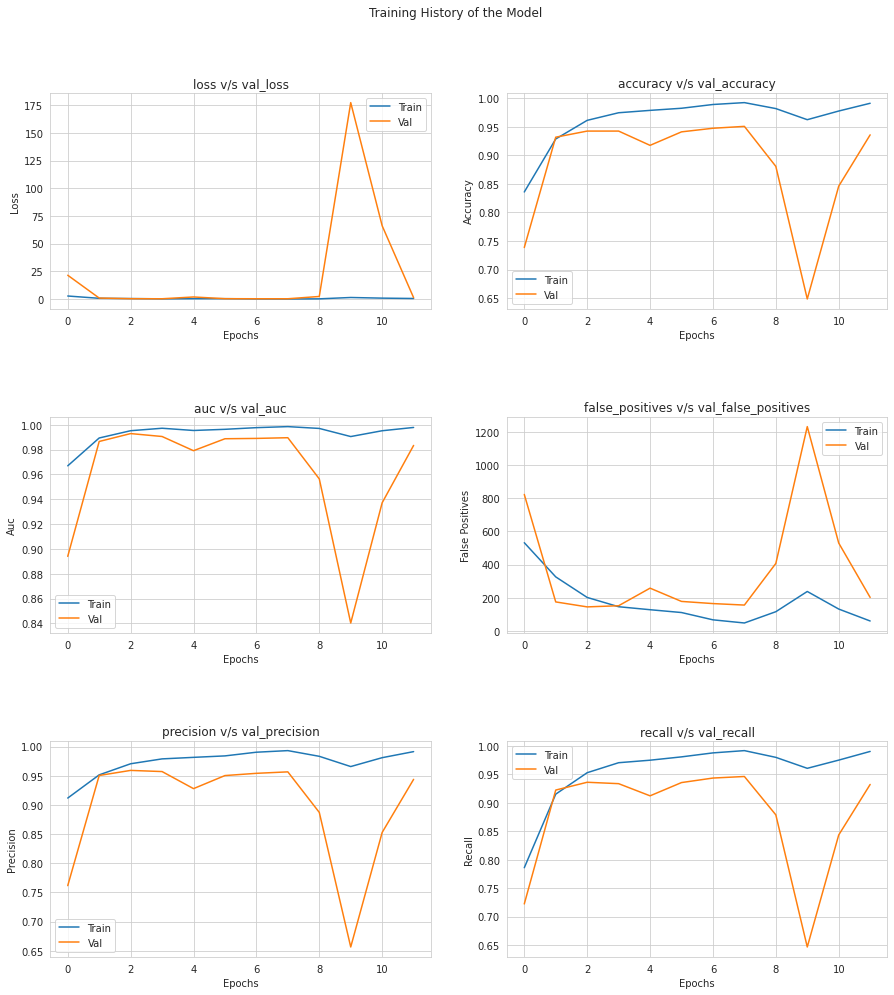

In [61]:
me.training_history()

##### Classification Metrics

              precision    recall  f1-score   support

    Adposhel       0.91      1.00      0.95        70
       Agent       0.79      0.86      0.82        70
     Allaple       0.95      0.90      0.93        70
   Amonetize       0.91      0.99      0.95        70
      Androm       0.95      0.83      0.89        70
     Autorun       0.84      0.81      0.83        70
   BrowseFox       0.97      0.96      0.96        70
      Dinwod       0.99      1.00      0.99        70
        Elex       0.92      0.97      0.94        70
      Expiro       0.87      0.94      0.90        70
      Fasong       1.00      0.93      0.96        70
     HackKMS       1.00      1.00      1.00        70
        Hlux       1.00      1.00      1.00        70
    Injector       0.91      0.71      0.80        70
 InstallCore       1.00      0.99      0.99        70
   MultiPlug       0.92      0.97      0.94        70
  Neoreklami       0.99      1.00      0.99        70
      Neshta       0.89    

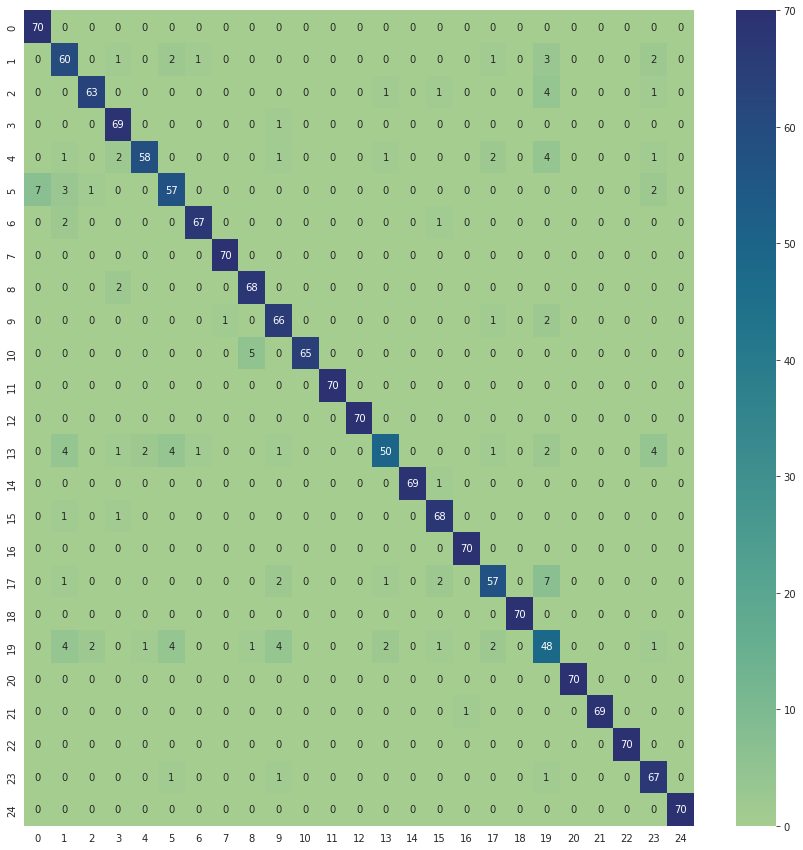

In [62]:
me.predict()
me.class_report()

#### Saving essential data

In [63]:
malevis_models["ResNet50"] = {"Ground Truth": test.labels.tolist(), 
                              "Predictions":np.array(me.predictions).tolist(), 
                              "History": history.history}

### Blended Dataset

#### Model Training

In [64]:
model, history, test = experiment_model(cnns.resnet,
                                        "blended",blended_data_dir, 
                                        (75, 75),
                                        cnns.ResNet50(include_top=False, 
                                                      input_shape=(75, 75, 3)), 
                                        31, "val", 
                                        False, 5)

Found 7892 images belonging to 31 classes.
Found 3879 images belonging to 31 classes.
Found 1976 images belonging to 31 classes.
Epoch 1/80
247/247 [==============================] - 62s 233ms/step - loss: 1.0789 - accuracy: 0.8349 - auc: 0.9729 - false_positives: 617.0000 - precision: 0.9095 - recall: 0.7859 - val_loss: 11.0526 - val_accuracy: 0.6208 - val_auc: 0.8666 - val_false_positives: 1067.0000 - val_precision: 0.6775 - val_recall: 0.5780
Epoch 2/80
247/247 [==============================] - 38s 153ms/step - loss: 0.3162 - accuracy: 0.9372 - auc: 0.9936 - false_positives: 334.0000 - precision: 0.9562 - recall: 0.9237 - val_loss: 0.6099 - val_accuracy: 0.8925 - val_auc: 0.9708 - val_false_positives: 345.0000 - val_precision: 0.9085 - val_recall: 0.8835
Epoch 3/80
247/247 [==============================] - 38s 154ms/step - loss: 0.1828 - accuracy: 0.9701 - auc: 0.9964 - false_positives: 194.0000 - precision: 0.9752 - recall: 0.9652 - val_loss: 0.3180 - val_accuracy: 0.9330 - val_a

#### Model Evaluation

##### Initialization of evaluator

In [65]:
me = ModelEvaluator(history, list(test.class_indices.keys()), model, test)

##### Training History

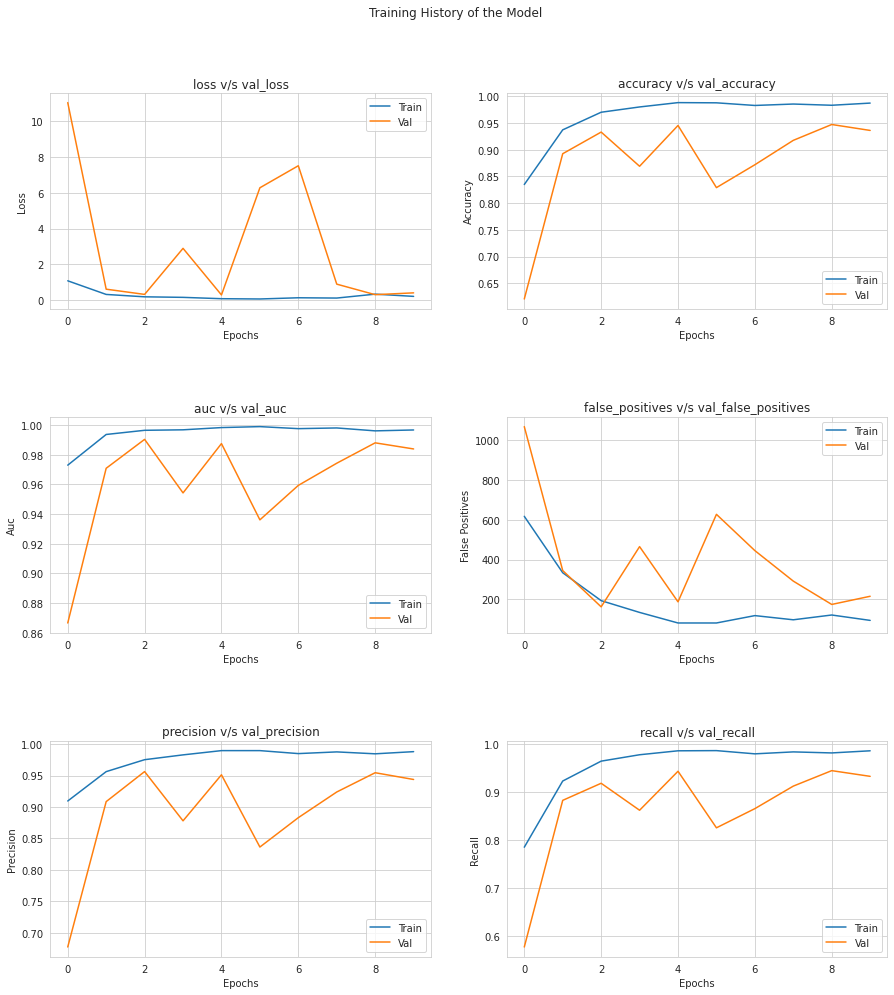

In [66]:
me.training_history()

##### Classification Metrics

                precision    recall  f1-score   support

      Adposhel       1.00      1.00      1.00        70
         Agent       0.83      0.84      0.84        70
       Allaple       0.99      0.96      0.97        70
 Alueron.gen!J       1.00      1.00      1.00        35
     Amonetize       0.99      0.96      0.97        70
        Androm       0.84      0.90      0.87        70
       Autorun       0.86      0.93      0.89        70
     BrowseFox       1.00      0.99      0.99        70
   C2LOP.gen!g       1.00      1.00      1.00        35
Dialplatform.B       1.00      1.00      1.00        31
        Dinwod       0.99      1.00      0.99        70
          Elex       0.97      0.97      0.97        70
        Expiro       0.82      0.93      0.87        70
      Fakerean       1.00      1.00      1.00        62
        Fasong       1.00      0.99      0.99        70
       HackKMS       1.00      1.00      1.00        70
          Hlux       0.99      1.00      0.99  

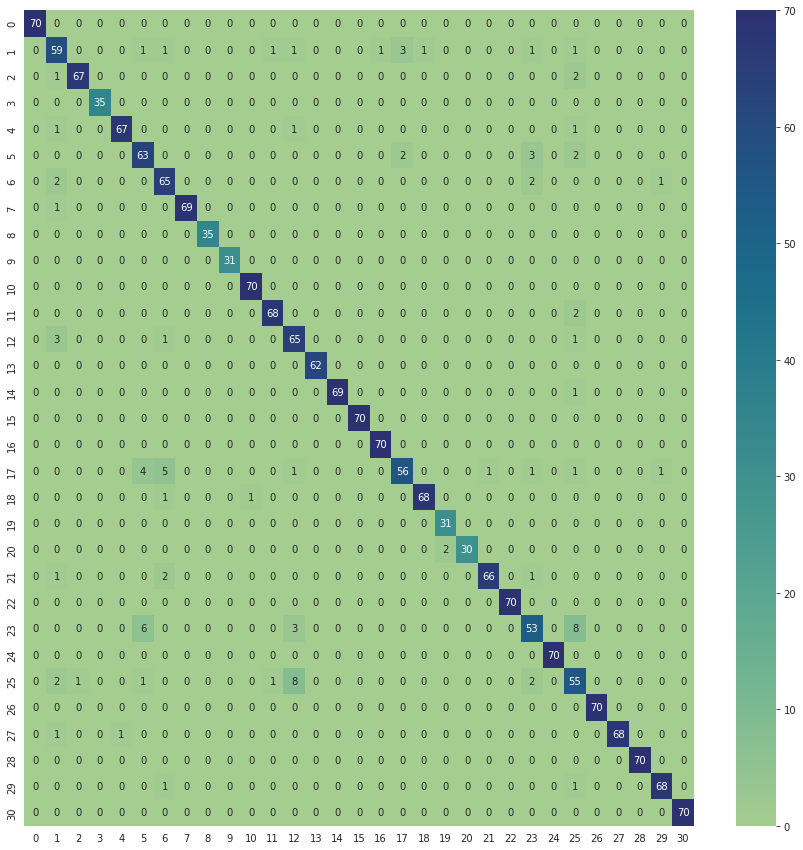

In [67]:
me.predict()
me.class_report()

#### Saving essential data

In [68]:
blended_models["ResNet50"] = {"Ground Truth": test.labels.tolist(), 
                              "Predictions":np.array(me.predictions).tolist(), 
                              "History": history.history}

## VGG16

### Malimg Dataset

#### Model Training

In [69]:
model, history, test = experiment_model(cnns.vgg16,
                                        "malimg",malimg_dir,
                                        (75,75),
                                        cnns.VGG16(include_top=False, 
                                                   input_shape=(75, 75, 3)), 
                                        25, "validation", 
                                        False, 3)

Found 6711 images belonging to 25 classes.
Found 910 images belonging to 25 classes.
Found 1693 images belonging to 25 classes.
Epoch 1/80
210/210 [==============================] - 19s 84ms/step - loss: 2.0322 - accuracy: 0.7640 - auc: 0.9395 - false_positives: 1539.0000 - precision: 0.7686 - recall: 0.7617 - val_loss: 0.6088 - val_accuracy: 0.8319 - val_auc: 0.9792 - val_false_positives: 136.0000 - val_precision: 0.8468 - val_recall: 0.8264
Epoch 2/80
210/210 [==============================] - 16s 75ms/step - loss: 0.4411 - accuracy: 0.8632 - auc: 0.9880 - false_positives: 876.0000 - precision: 0.8680 - recall: 0.8586 - val_loss: 0.5920 - val_accuracy: 0.8681 - val_auc: 0.9794 - val_false_positives: 113.0000 - val_precision: 0.8746 - val_recall: 0.8659
Epoch 3/80
210/210 [==============================] - 16s 77ms/step - loss: 0.3536 - accuracy: 0.8726 - auc: 0.9921 - false_positives: 804.0000 - precision: 0.8787 - recall: 0.8675 - val_loss: 0.3788 - val_accuracy: 0.8538 - val_auc: 0

#### Model Evaluation

##### Initialization of evaluator

In [70]:
me = ModelEvaluator(history, list(test.class_indices.keys()), model, test)

##### Training History

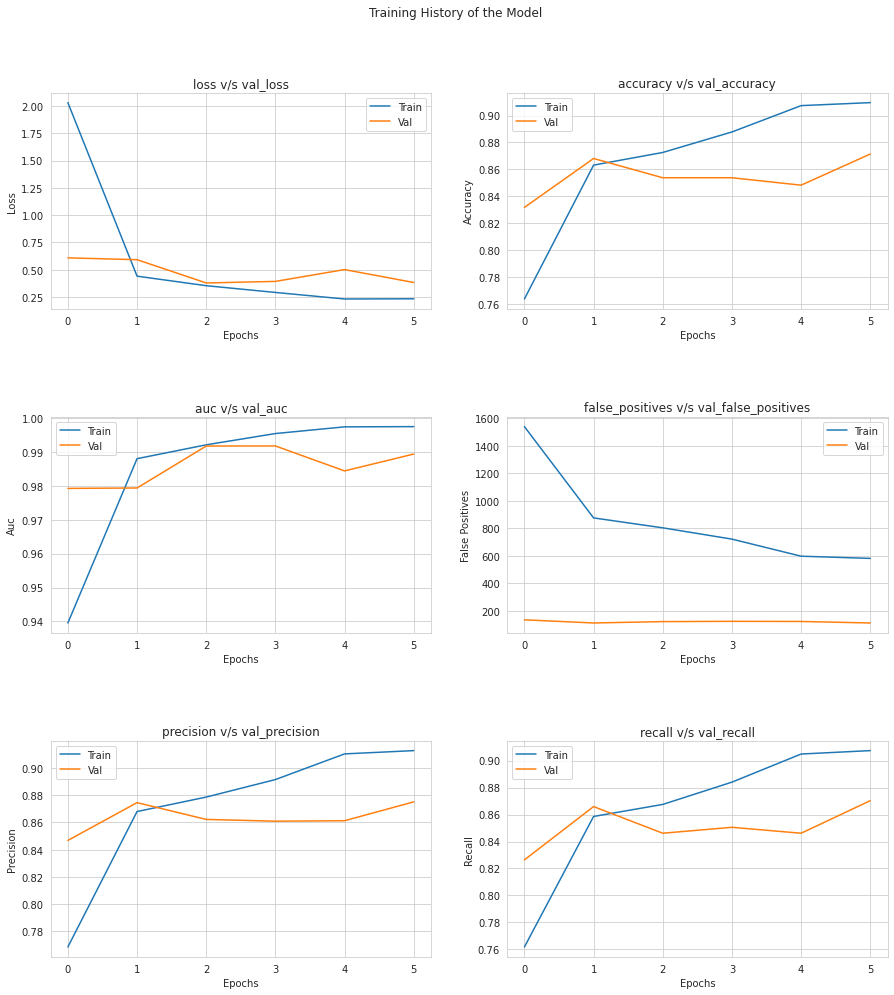

In [71]:
me.training_history()

##### Classification Metrics

/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


                precision    recall  f1-score   support

     Adialer.C       1.00      1.00      1.00        20
     Agent.FYI       1.00      1.00      1.00        19
     Allaple.A       0.90      0.86      0.88       565
     Allaple.L       0.76      0.84      0.80       299
 Alueron.gen!J       0.97      1.00      0.99        35
     Autorun.K       0.10      1.00      0.18        17
       C2LOP.P       0.81      0.68      0.74        25
   C2LOP.gen!g       0.77      0.77      0.77        35
Dialplatform.B       1.00      0.97      0.98        31
     Dontovo.A       1.00      1.00      1.00        28
      Fakerean       0.95      1.00      0.98        62
 Instantaccess       0.96      1.00      0.98        72
    Lolyda.AA1       0.91      0.94      0.92        31
    Lolyda.AA2       1.00      0.94      0.97        32
    Lolyda.AA3       1.00      1.00      1.00        20
     Lolyda.AT       0.93      0.96      0.95        27
   Malex.gen!J       0.82      0.78      0.80  

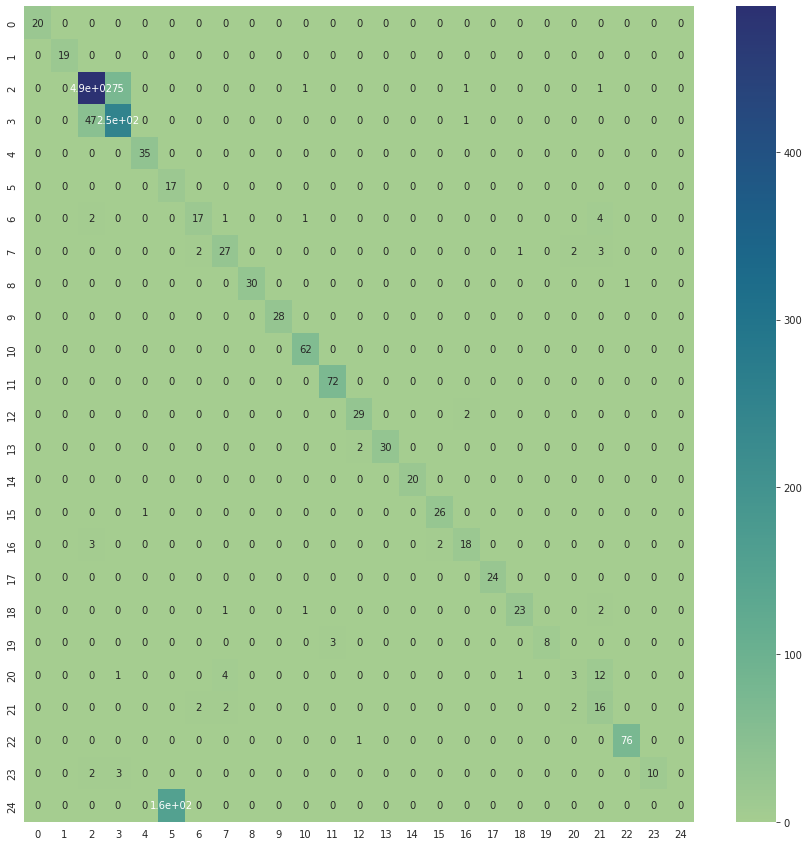

In [72]:
me.predict()
me.class_report()

#### Saving essential data

In [73]:
malimg_models["VGG16"] = {"Ground Truth": test.labels.tolist(), 
                          "Predictions":np.array(me.predictions).tolist(), 
                          "History": history.history}

### Malevis Dataset

#### Model Training

In [74]:
model, history, test = experiment_model(cnns.vgg16,
                                        "malevis",malevis_dir, 
                                        (200,200),
                                        cnns.VGG16(include_top=False, 
                                                   input_shape=(200, 200, 3)), 
                                        25, "val", 
                                        False, 8)

Found 7000 images belonging to 25 classes.
Found 3644 images belonging to 25 classes.
Found 1750 images belonging to 25 classes.
Epoch 1/80
219/219 [==============================] - 57s 243ms/step - loss: 3.1316 - accuracy: 0.8516 - auc: 0.9406 - false_positives: 991.0000 - precision: 0.8571 - recall: 0.8494 - val_loss: 0.5887 - val_accuracy: 0.9158 - val_auc: 0.9801 - val_false_positives: 249.0000 - val_precision: 0.9303 - val_recall: 0.9119
Epoch 2/80
219/219 [==============================] - 45s 205ms/step - loss: 0.3085 - accuracy: 0.9573 - auc: 0.9915 - false_positives: 270.0000 - precision: 0.9612 - recall: 0.9543 - val_loss: 0.5167 - val_accuracy: 0.9330 - val_auc: 0.9817 - val_false_positives: 202.0000 - val_precision: 0.9437 - val_recall: 0.9292
Epoch 3/80
219/219 [==============================] - 45s 204ms/step - loss: 0.1705 - accuracy: 0.9721 - auc: 0.9941 - false_positives: 175.0000 - precision: 0.9749 - recall: 0.9700 - val_loss: 0.9748 - val_accuracy: 0.9168 - val_auc

#### Model Evaluation

##### Initialization of evaluator

In [75]:
me = ModelEvaluator(history, list(test.class_indices.keys()), model, test)

##### Training History

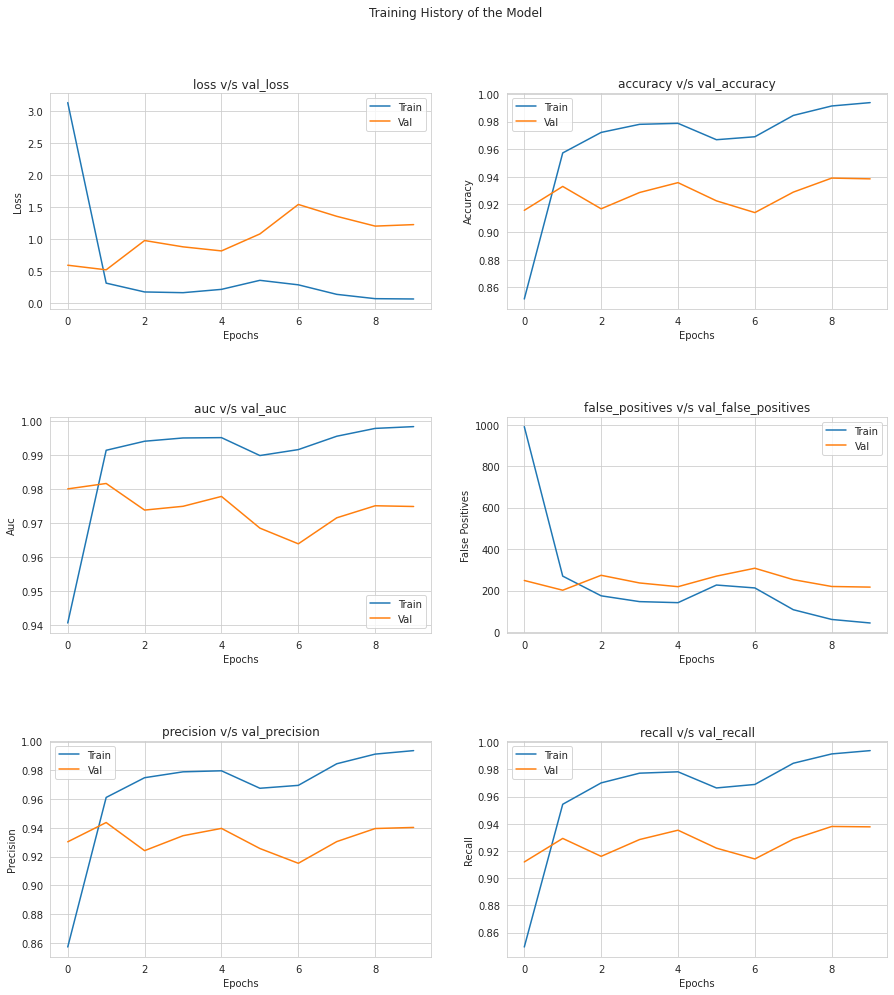

In [76]:
me.training_history()

##### Classification Metrics

              precision    recall  f1-score   support

    Adposhel       1.00      1.00      1.00        70
       Agent       0.83      0.84      0.84        70
     Allaple       0.99      1.00      0.99        70
   Amonetize       0.96      0.96      0.96        70
      Androm       0.81      0.86      0.83        70
     Autorun       0.84      0.87      0.85        70
   BrowseFox       0.96      0.99      0.97        70
      Dinwod       0.96      1.00      0.98        70
        Elex       1.00      1.00      1.00        70
      Expiro       0.67      0.83      0.74        70
      Fasong       1.00      1.00      1.00        70
     HackKMS       1.00      0.99      0.99        70
        Hlux       1.00      1.00      1.00        70
    Injector       0.71      0.84      0.77        70
 InstallCore       0.97      1.00      0.99        70
   MultiPlug       1.00      0.93      0.96        70
  Neoreklami       0.97      0.99      0.98        70
      Neshta       0.76    

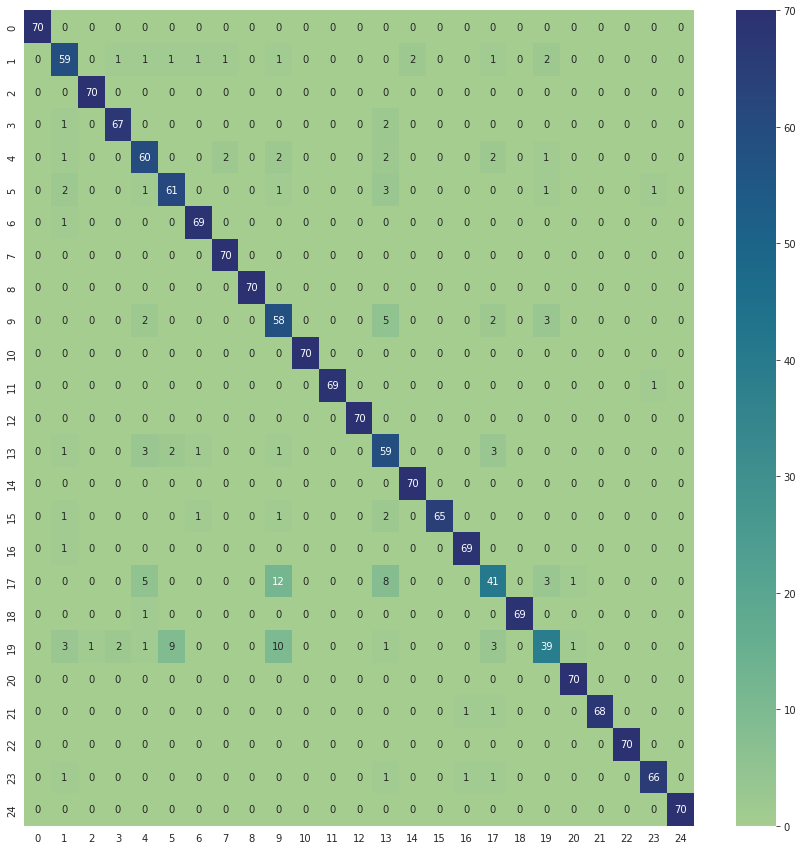

In [77]:
me.predict()
me.class_report()

#### Saving essential data

In [78]:
malevis_models["VGG16"] = {"Ground Truth": test.labels.tolist(), 
                           "Predictions":np.array(me.predictions).tolist(), 
                           "History": history.history}

### Blended Dataset

#### Model Training

In [79]:
model, history, test = experiment_model(cnns.vgg16,
                                        "blended",blended_data_dir, 
                                        (75, 75),
                                        cnns.VGG16(include_top=False, 
                                                   input_shape=(75, 75, 3)), 
                                        31, "val", 
                                        False, 5)

Found 7892 images belonging to 31 classes.
Found 3879 images belonging to 31 classes.
Found 1976 images belonging to 31 classes.
Epoch 1/80
247/247 [==============================] - 41s 159ms/step - loss: 1.6577 - accuracy: 0.8212 - auc: 0.9440 - false_positives: 1242.0000 - precision: 0.8379 - recall: 0.8136 - val_loss: 0.6109 - val_accuracy: 0.8886 - val_auc: 0.9746 - val_false_positives: 327.0000 - val_precision: 0.9125 - val_recall: 0.8791
Epoch 2/80
247/247 [==============================] - 36s 145ms/step - loss: 0.2808 - accuracy: 0.9349 - auc: 0.9912 - false_positives: 401.0000 - precision: 0.9481 - recall: 0.9274 - val_loss: 0.6615 - val_accuracy: 0.8861 - val_auc: 0.9740 - val_false_positives: 359.0000 - val_precision: 0.9046 - val_recall: 0.8773
Epoch 3/80
247/247 [==============================] - 36s 146ms/step - loss: 0.1849 - accuracy: 0.9545 - auc: 0.9950 - false_positives: 294.0000 - precision: 0.9622 - recall: 0.9492 - val_loss: 0.6072 - val_accuracy: 0.9005 - val_au

#### Model Evaluation

##### Initialization of evaluator

In [80]:
me = ModelEvaluator(history, list(test.class_indices.keys()), model, test)

##### Training History

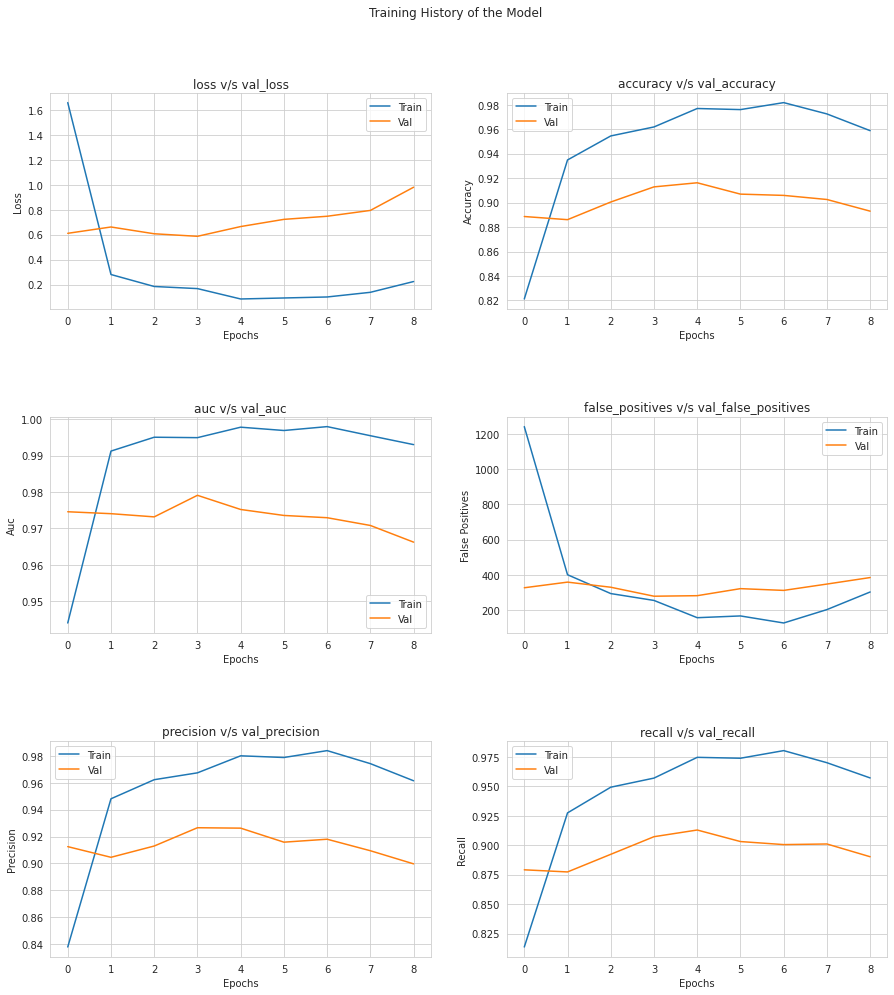

In [81]:
me.training_history()

##### Classification Metrics

                precision    recall  f1-score   support

      Adposhel       1.00      1.00      1.00        70
         Agent       0.86      0.81      0.84        70
       Allaple       0.89      0.91      0.90        70
 Alueron.gen!J       0.97      1.00      0.99        35
     Amonetize       0.88      0.96      0.92        70
        Androm       0.79      0.79      0.79        70
       Autorun       0.88      0.84      0.86        70
     BrowseFox       0.94      0.97      0.96        70
   C2LOP.gen!g       1.00      1.00      1.00        35
Dialplatform.B       1.00      0.97      0.98        31
        Dinwod       0.97      0.96      0.96        70
          Elex       0.99      0.96      0.97        70
        Expiro       0.65      0.76      0.70        70
      Fakerean       1.00      1.00      1.00        62
        Fasong       1.00      1.00      1.00        70
       HackKMS       1.00      0.99      0.99        70
          Hlux       1.00      1.00      1.00  

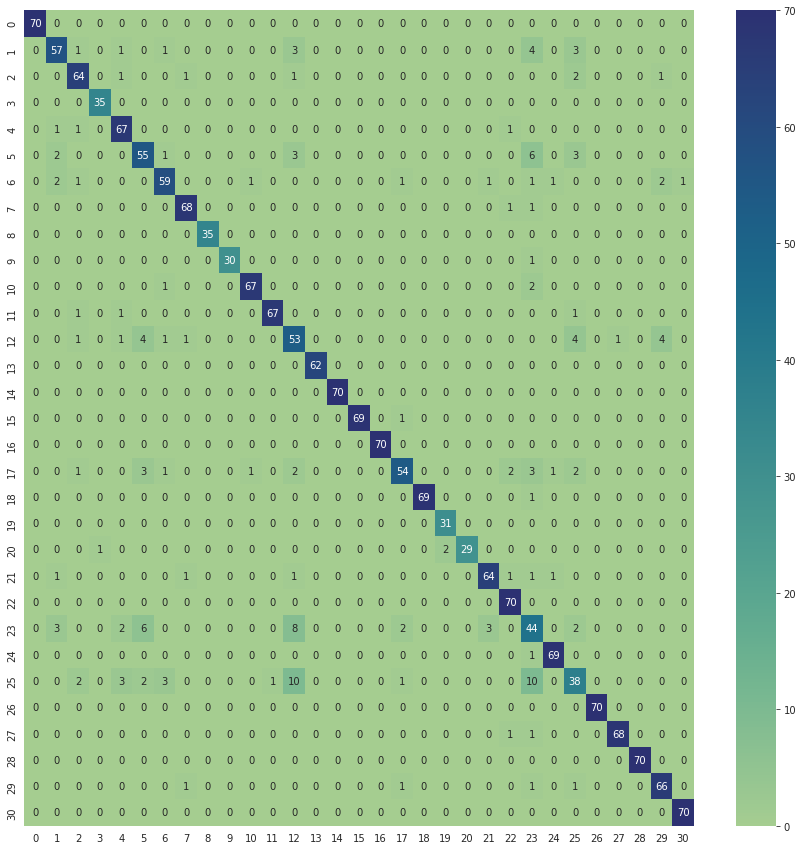

In [82]:
me.predict()
me.class_report()

#### Saving essential data

In [83]:
blended_models["VGG16"] = {"Ground Truth": test.labels.tolist(), 
                           "Predictions":np.array(me.predictions).tolist(), 
                           "History": history.history}

## DenseNet

### Malimg Dataset

#### Model Training

In [92]:
model, history, test = experiment_model(cnns.densenet,
                                        "malimg",malimg_dir,
                                        (75,75),
                                        cnns.DenseNet169(include_top=False, 
                                                         input_shape=(75, 75, 3)), 
                                        25, "validation", 
                                        False, 3)

51888128/51877672 [==============================] - 0s 0us/step
Found 6711 images belonging to 25 classes.
Found 910 images belonging to 25 classes.
Found 1693 images belonging to 25 classes.
Epoch 1/80
210/210 [==============================] - 49s 158ms/step - loss: 0.9008 - accuracy: 0.8026 - auc: 0.9738 - false_positives: 809.0000 - precision: 0.8630 - recall: 0.7591 - val_loss: 1.9252 - val_accuracy: 0.7484 - val_auc: 0.9534 - val_false_positives: 183.0000 - val_precision: 0.7795 - val_recall: 0.7110
Epoch 2/80
210/210 [==============================] - 28s 133ms/step - loss: 0.2153 - accuracy: 0.9332 - auc: 0.9963 - false_positives: 368.0000 - precision: 0.9440 - recall: 0.9245 - val_loss: 0.2742 - val_accuracy: 0.9220 - val_auc: 0.9828 - val_false_positives: 63.0000 - val_precision: 0.9297 - val_recall: 0.9154
Epoch 3/80
210/210 [==============================] - 28s 135ms/step - loss: 0.1403 - accuracy: 0.9559 - auc: 0.9978 - false_positives: 271.0000 - precision: 0.9593 - rec

#### Model Evaluation

##### Initialization of the evaluator

In [93]:
me = ModelEvaluator(history, list(test.class_indices.keys()), model, test)

##### Training History

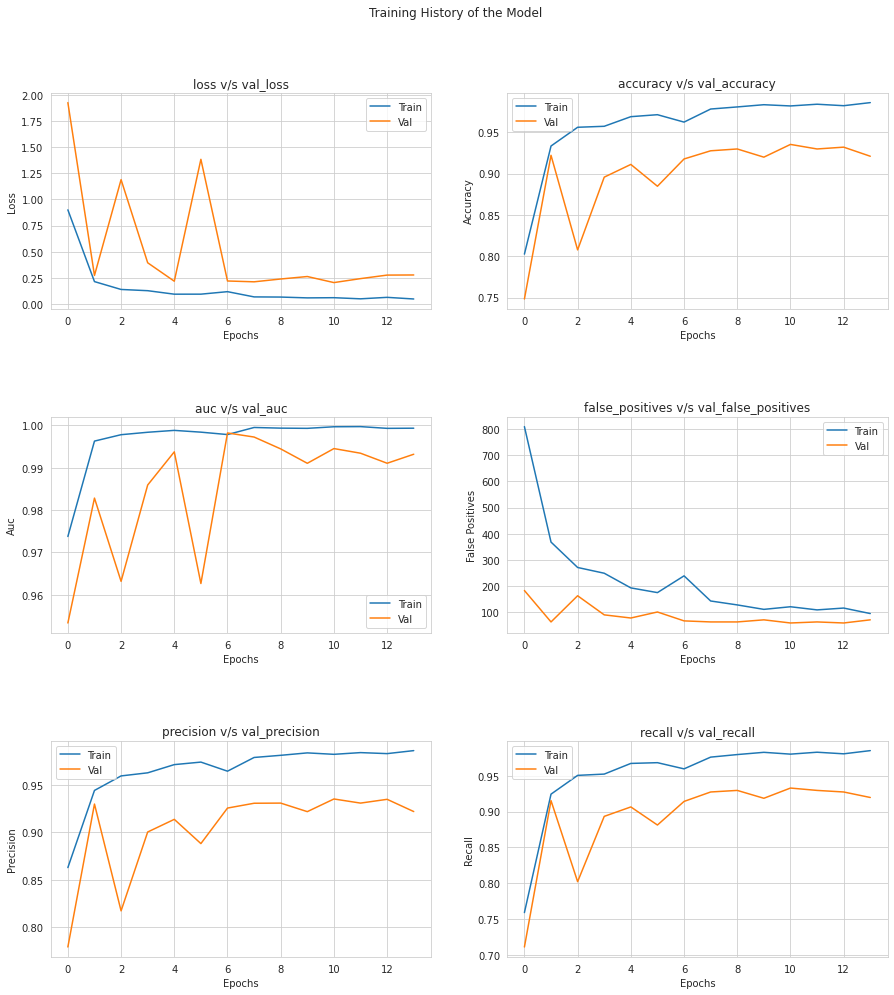

In [94]:
me.training_history()

##### Classification Metrics

/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


                precision    recall  f1-score   support

     Adialer.C       0.95      1.00      0.98        20
     Agent.FYI       1.00      1.00      1.00        19
     Allaple.A       0.98      0.99      0.99       565
     Allaple.L       0.98      0.99      0.98       299
 Alueron.gen!J       1.00      1.00      1.00        35
     Autorun.K       0.00      0.00      0.00        17
       C2LOP.P       0.89      0.64      0.74        25
   C2LOP.gen!g       0.76      0.91      0.83        35
Dialplatform.B       1.00      1.00      1.00        31
     Dontovo.A       1.00      1.00      1.00        28
      Fakerean       0.98      1.00      0.99        62
 Instantaccess       1.00      1.00      1.00        72
    Lolyda.AA1       0.90      0.87      0.89        31
    Lolyda.AA2       1.00      0.94      0.97        32
    Lolyda.AA3       1.00      1.00      1.00        20
     Lolyda.AT       1.00      0.96      0.98        27
   Malex.gen!J       0.95      0.87      0.91  

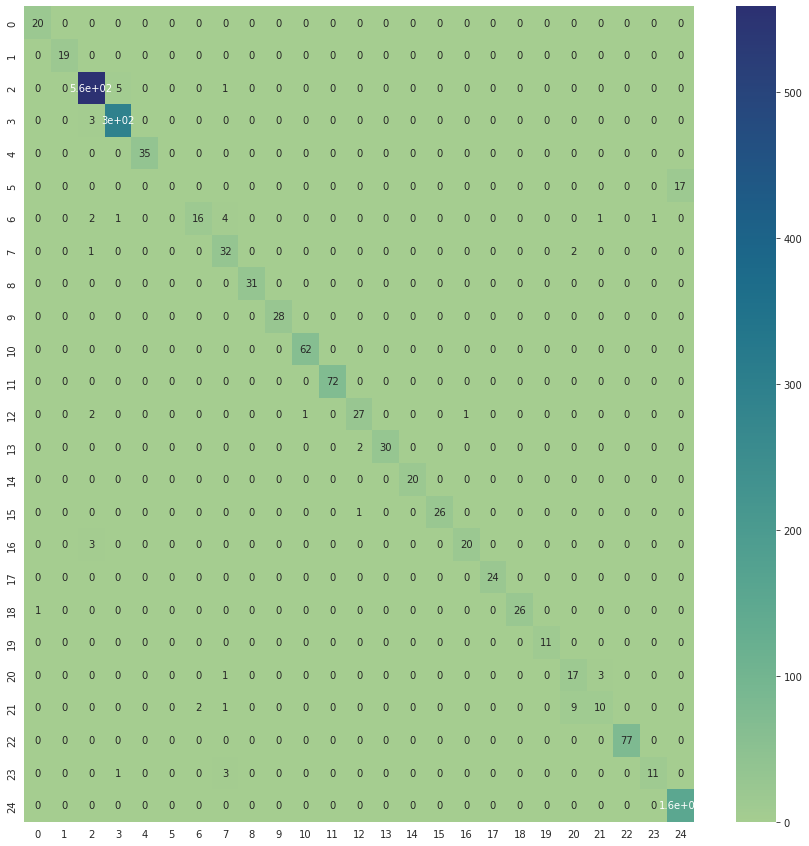

In [95]:
me.predict()
me.class_report()

#### Saving essential data

In [96]:
malimg_models["DenseNet169"] = {"Ground Truth": test.labels.tolist(), 
                                "Predictions":np.array(me.predictions).tolist(), 
                                "History": history.history}

### Malevis Dataset

#### Model Training

In [97]:
model, history, test = experiment_model(cnns.densenet,
                                        "malevis",malevis_dir, 
                                        (200,200),
                                        cnns.DenseNet169(include_top=False, 
                                                         input_shape=(200, 200, 3)), 
                                        25, "val", 
                                        False, 8)

Found 7000 images belonging to 25 classes.
Found 3644 images belonging to 25 classes.
Found 1750 images belonging to 25 classes.
Epoch 1/80
219/219 [==============================] - 78s 282ms/step - loss: 5.8790 - accuracy: 0.5306 - auc: 0.8708 - false_positives: 891.0000 - precision: 0.7678 - recall: 0.4209 - val_loss: 9.1042 - val_accuracy: 0.6229 - val_auc: 0.8744 - val_false_positives: 903.0000 - val_precision: 0.7037 - val_recall: 0.5886
Epoch 2/80
219/219 [==============================] - 56s 254ms/step - loss: 1.2406 - accuracy: 0.8099 - auc: 0.9750 - false_positives: 530.0000 - precision: 0.9075 - recall: 0.7424 - val_loss: 0.5506 - val_accuracy: 0.8301 - val_auc: 0.9807 - val_false_positives: 385.0000 - val_precision: 0.8833 - val_recall: 0.7999
Epoch 3/80
219/219 [==============================] - 56s 255ms/step - loss: 0.9242 - accuracy: 0.8541 - auc: 0.9808 - false_positives: 522.0000 - precision: 0.9162 - recall: 0.8151 - val_loss: 78.3808 - val_accuracy: 0.4383 - val_au

#### Model Evaluation

##### Initialization of the evaluator

In [98]:
me = ModelEvaluator(history, list(test.class_indices.keys()), model, test)

##### Training History

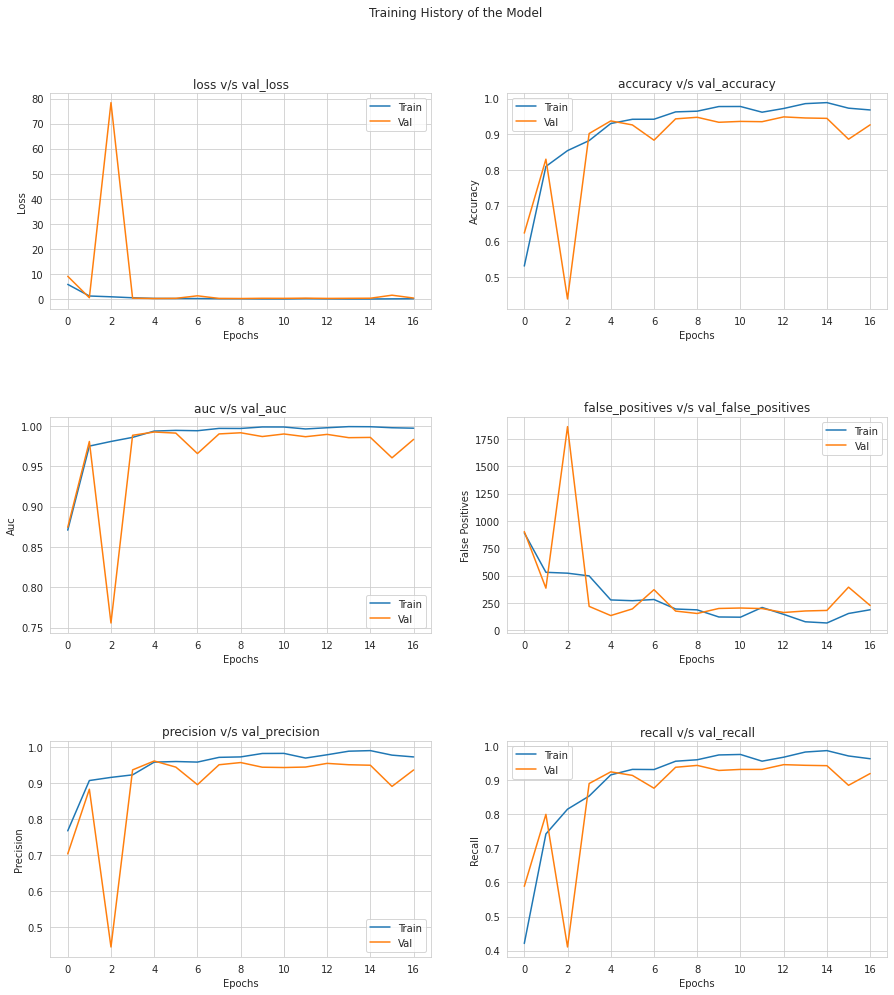

In [99]:
me.training_history()

##### Classification Metrics

              precision    recall  f1-score   support

    Adposhel       1.00      1.00      1.00        70
       Agent       0.89      0.83      0.86        70
     Allaple       0.97      0.97      0.97        70
   Amonetize       0.99      0.96      0.97        70
      Androm       0.78      0.87      0.82        70
     Autorun       0.81      0.97      0.88        70
   BrowseFox       0.99      0.99      0.99        70
      Dinwod       0.99      1.00      0.99        70
        Elex       1.00      0.99      0.99        70
      Expiro       0.91      0.97      0.94        70
      Fasong       1.00      1.00      1.00        70
     HackKMS       1.00      1.00      1.00        70
        Hlux       1.00      1.00      1.00        70
    Injector       0.85      0.86      0.85        70
 InstallCore       1.00      1.00      1.00        70
   MultiPlug       0.99      0.97      0.98        70
  Neoreklami       1.00      1.00      1.00        70
      Neshta       0.96    

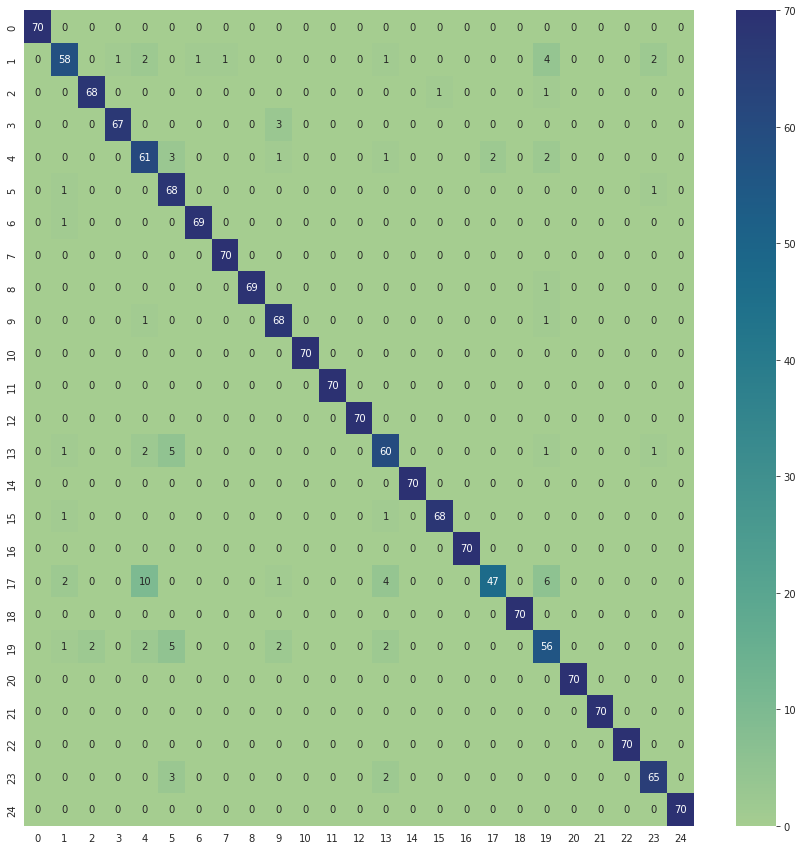

In [100]:
me.predict()
me.class_report()

#### Saving essential data

In [101]:
malevis_models["DenseNet169"] = {"Ground Truth": test.labels.tolist(), 
                                 "Predictions":np.array(me.predictions).tolist(), 
                                 "History": history.history}

### Blended Dataset

#### Model Training

In [102]:
model, history, test = experiment_model(cnns.densenet,
                                        "blended",blended_data_dir, 
                                        (75, 75),
                                        cnns.DenseNet169(include_top=False, 
                                                         input_shape=(75, 75, 3)), 
                                        31, "val", 
                                        False, 5)

Found 7892 images belonging to 31 classes.
Found 3879 images belonging to 31 classes.
Found 1976 images belonging to 31 classes.
Epoch 1/80
247/247 [==============================] - 78s 258ms/step - loss: 1.3740 - accuracy: 0.7206 - auc: 0.9576 - false_positives: 755.0000 - precision: 0.8697 - recall: 0.6386 - val_loss: 1.0139 - val_accuracy: 0.8154 - val_auc: 0.9602 - val_false_positives: 509.0000 - val_precision: 0.8583 - val_recall: 0.7948
Epoch 2/80
247/247 [==============================] - 47s 192ms/step - loss: 0.3707 - accuracy: 0.8983 - auc: 0.9916 - false_positives: 422.0000 - precision: 0.9416 - recall: 0.8619 - val_loss: 0.4681 - val_accuracy: 0.8804 - val_auc: 0.9854 - val_false_positives: 259.0000 - val_precision: 0.9275 - val_recall: 0.8536
Epoch 3/80
247/247 [==============================] - 60s 243ms/step - loss: 0.2378 - accuracy: 0.9309 - auc: 0.9948 - false_positives: 306.0000 - precision: 0.9592 - recall: 0.9119 - val_loss: 0.2853 - val_accuracy: 0.9260 - val_auc

#### Model Evaluation

##### Initialization of the evaluator

In [103]:
me = ModelEvaluator(history, list(test.class_indices.keys()), model, test)

##### Training History

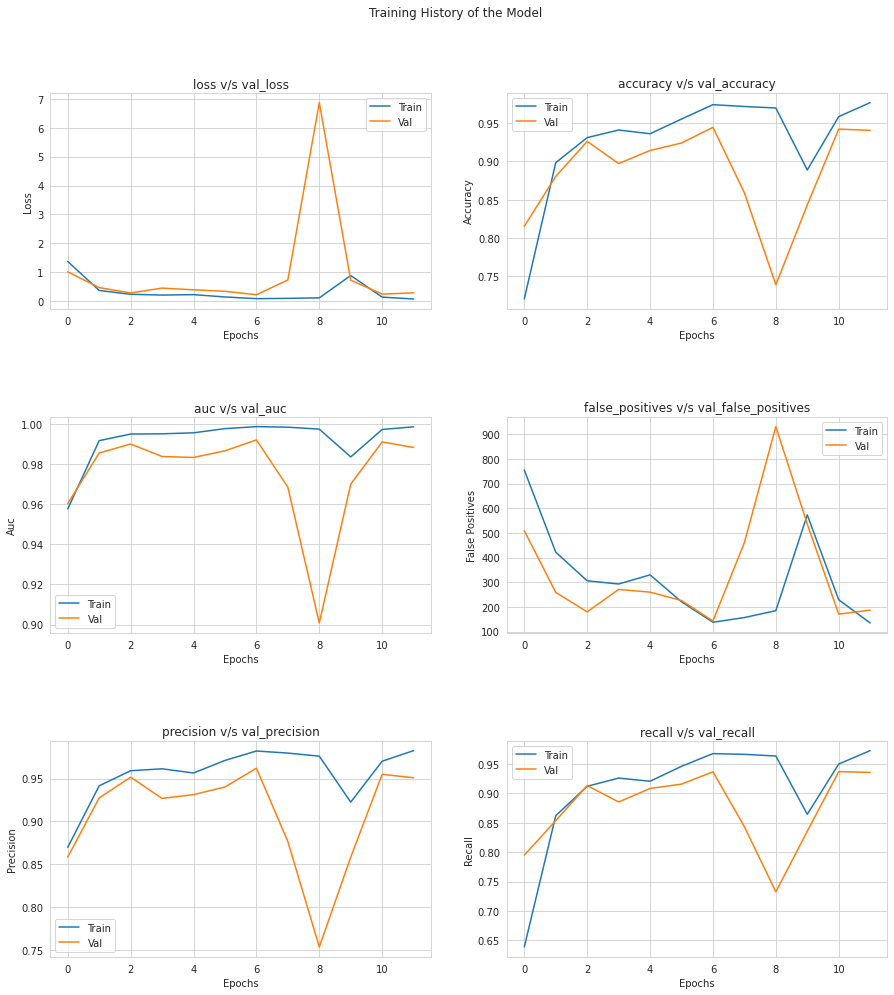

In [104]:
me.training_history()

##### Classification Metrics

                precision    recall  f1-score   support

      Adposhel       1.00      1.00      1.00        70
         Agent       0.79      0.83      0.81        70
       Allaple       0.96      0.97      0.96        70
 Alueron.gen!J       1.00      1.00      1.00        35
     Amonetize       0.94      0.96      0.95        70
        Androm       0.90      0.74      0.81        70
       Autorun       0.83      0.91      0.87        70
     BrowseFox       0.97      0.99      0.98        70
   C2LOP.gen!g       1.00      1.00      1.00        35
Dialplatform.B       1.00      1.00      1.00        31
        Dinwod       1.00      1.00      1.00        70
          Elex       0.99      0.97      0.98        70
        Expiro       0.84      0.77      0.81        70
      Fakerean       1.00      1.00      1.00        62
        Fasong       1.00      1.00      1.00        70
       HackKMS       1.00      0.99      0.99        70
          Hlux       0.99      1.00      0.99  

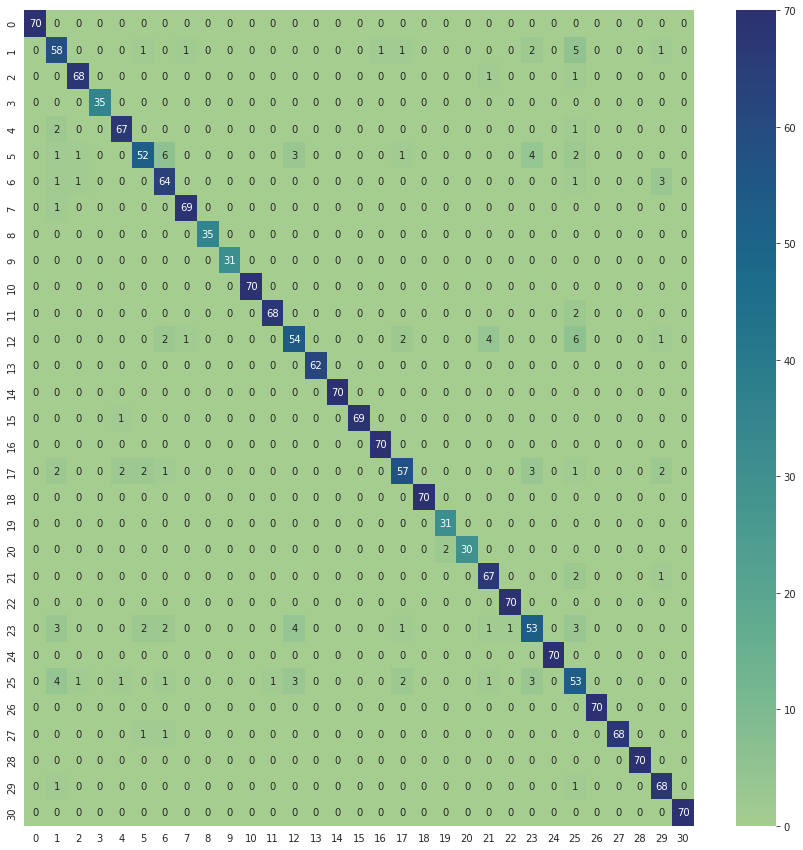

In [105]:
me.predict()
me.class_report()

#### Saving essential data

In [106]:
blended_models["DenseNet169"] = {"Ground Truth": test.labels.tolist(), 
                                 "Predictions":np.array(me.predictions).tolist(), 
                                 "History": history.history}

## Inception ResNet V2

#### Model Training

In [114]:
model, history, test = experiment_model(cnns.inception_resnet_v2,
                                        "malimg",malimg_dir,
                                        (75,75),
                                        cnns.InceptionResNetV2(include_top=False, 
                                                               input_shape=(75, 75, 3)), 
                                        25, "validation", 
                                        False, 3)

219070464/219055592 [==============================] - 1s 0us/step
Found 6711 images belonging to 25 classes.
Found 910 images belonging to 25 classes.
Found 1693 images belonging to 25 classes.
Epoch 1/80
210/210 [==============================] - 60s 198ms/step - loss: 0.7187 - accuracy: 0.8045 - auc: 0.9781 - false_positives: 807.0000 - precision: 0.8624 - recall: 0.7538 - val_loss: 28.9959 - val_accuracy: 0.8451 - val_auc: 0.9811 - val_false_positives: 104.0000 - val_precision: 0.8750 - val_recall: 0.8000
Epoch 2/80
210/210 [==============================] - 32s 151ms/step - loss: 0.2303 - accuracy: 0.9239 - auc: 0.9958 - false_positives: 447.0000 - precision: 0.9323 - recall: 0.9166 - val_loss: 0.2796 - val_accuracy: 0.8901 - val_auc: 0.9979 - val_false_positives: 78.0000 - val_precision: 0.9104 - val_recall: 0.8714
Epoch 3/80
210/210 [==============================] - 32s 151ms/step - loss: 0.1281 - accuracy: 0.9596 - auc: 0.9981 - false_positives: 244.0000 - precision: 0.9634 - 

#### Model Evaluation

##### Initialization of the evaluator

In [115]:
me = ModelEvaluator(history, list(test.class_indices.keys()), model, test)

##### Training History

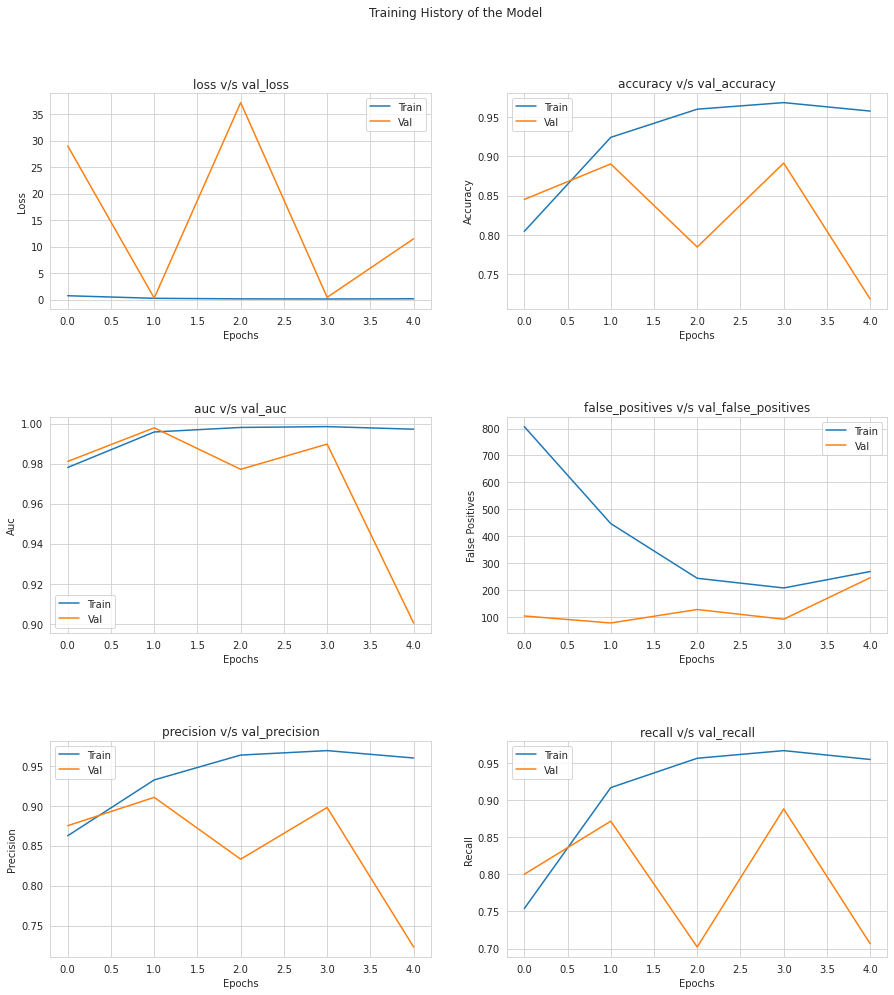

In [116]:
me.training_history()

##### Classification Metrics

/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


                precision    recall  f1-score   support

     Adialer.C       1.00      1.00      1.00        20
     Agent.FYI       1.00      1.00      1.00        19
     Allaple.A       0.98      0.86      0.92       565
     Allaple.L       0.82      0.98      0.89       299
 Alueron.gen!J       0.97      1.00      0.99        35
     Autorun.K       0.00      0.00      0.00        17
       C2LOP.P       0.76      0.76      0.76        25
   C2LOP.gen!g       0.82      0.91      0.86        35
Dialplatform.B       1.00      0.97      0.98        31
     Dontovo.A       1.00      1.00      1.00        28
      Fakerean       1.00      1.00      1.00        62
 Instantaccess       1.00      1.00      1.00        72
    Lolyda.AA1       0.97      0.90      0.93        31
    Lolyda.AA2       0.94      0.97      0.95        32
    Lolyda.AA3       1.00      1.00      1.00        20
     Lolyda.AT       1.00      0.96      0.98        27
   Malex.gen!J       0.63      0.83      0.72  

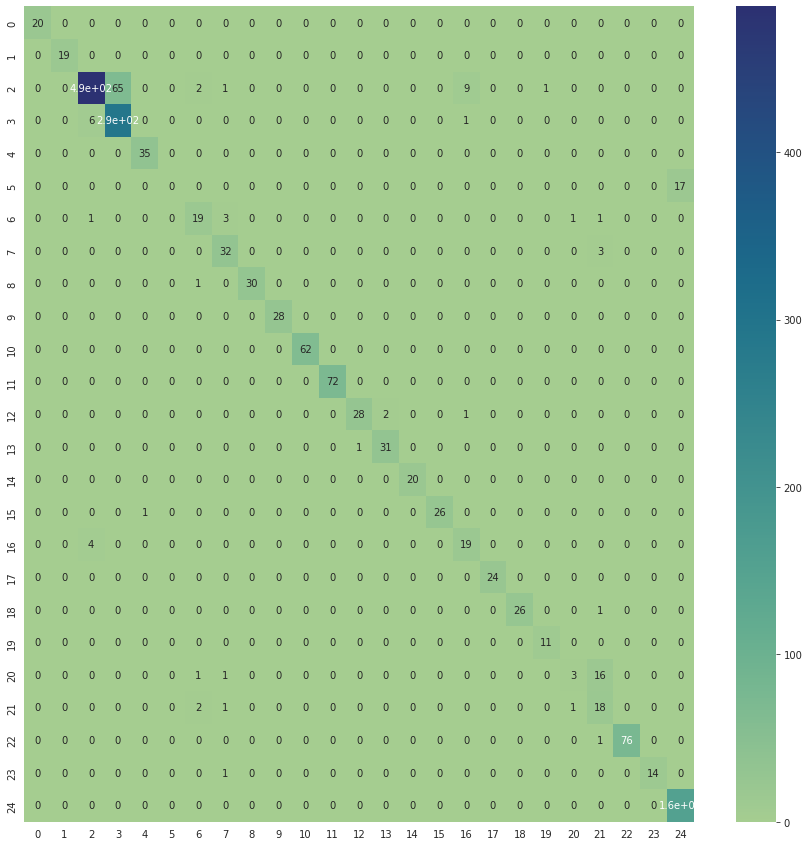

In [117]:
me.predict()
me.class_report()

#### Saving essential data

In [118]:
malimg_models["InceptionResNetV2"] = {"Ground Truth": test.labels.tolist(), 
                                      "Predictions":np.array(me.predictions).tolist(), 
                                      "History": history.history}

### Malevis Dataset

#### Model Training

In [119]:
model, history, test = experiment_model(cnns.inception_resnet_v2,
                                        "malevis",malevis_dir, (200,200),
                                        cnns.InceptionResNetV2(include_top=False, input_shape=(200, 200, 3)), 
                                        25, "val", False, 8)

Found 7000 images belonging to 25 classes.
Found 3644 images belonging to 25 classes.
Found 1750 images belonging to 25 classes.
Epoch 1/80
219/219 [==============================] - 96s 356ms/step - loss: 2.3127 - accuracy: 0.5687 - auc: 0.9043 - false_positives: 433.0000 - precision: 0.8798 - recall: 0.4527 - val_loss: 231.8481 - val_accuracy: 0.5560 - val_auc: 0.8606 - val_false_positives: 776.0000 - val_precision: 0.6717 - val_recall: 0.4358
Epoch 2/80
219/219 [==============================] - 71s 325ms/step - loss: 0.4447 - accuracy: 0.8760 - auc: 0.9873 - false_positives: 404.0000 - precision: 0.9360 - recall: 0.8444 - val_loss: 0.8178 - val_accuracy: 0.7827 - val_auc: 0.9704 - val_false_positives: 328.0000 - val_precision: 0.8881 - val_recall: 0.7143
Epoch 3/80
219/219 [==============================] - 73s 334ms/step - loss: 0.3346 - accuracy: 0.9107 - auc: 0.9910 - false_positives: 364.0000 - precision: 0.9445 - recall: 0.8850 - val_loss: 0.3943 - val_accuracy: 0.8856 - val_a

#### Model Evaluation

##### Initialization of the evaluator

In [120]:
me = ModelEvaluator(history, list(test.class_indices.keys()), model, test)

##### Training History

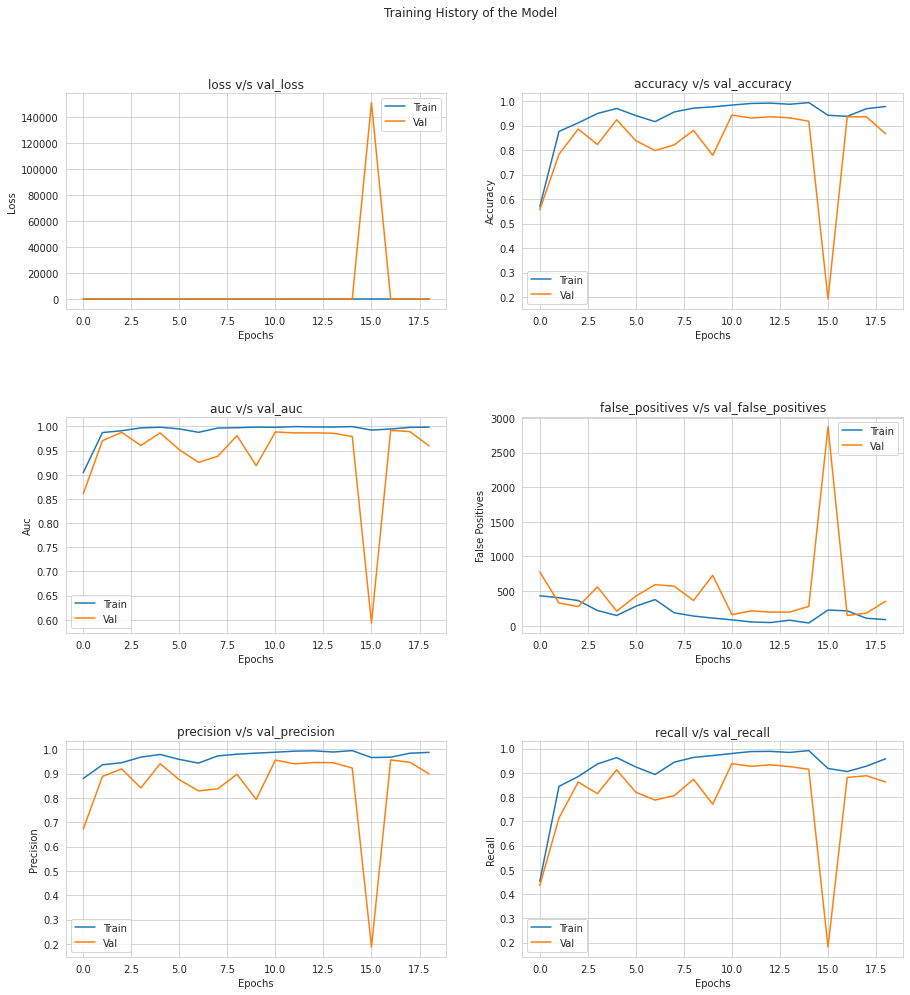

In [121]:
me.training_history()

##### Classification Metrics

              precision    recall  f1-score   support

    Adposhel       1.00      1.00      1.00        70
       Agent       0.94      0.73      0.82        70
     Allaple       0.97      0.94      0.96        70
   Amonetize       0.97      0.96      0.96        70
      Androm       0.88      0.81      0.84        70
     Autorun       0.89      0.91      0.90        70
   BrowseFox       0.95      1.00      0.97        70
      Dinwod       0.99      1.00      0.99        70
        Elex       0.90      1.00      0.95        70
      Expiro       0.70      0.90      0.79        70
      Fasong       1.00      1.00      1.00        70
     HackKMS       1.00      1.00      1.00        70
        Hlux       0.99      1.00      0.99        70
    Injector       0.97      0.80      0.88        70
 InstallCore       1.00      0.99      0.99        70
   MultiPlug       0.97      0.97      0.97        70
  Neoreklami       1.00      0.99      0.99        70
      Neshta       0.73    

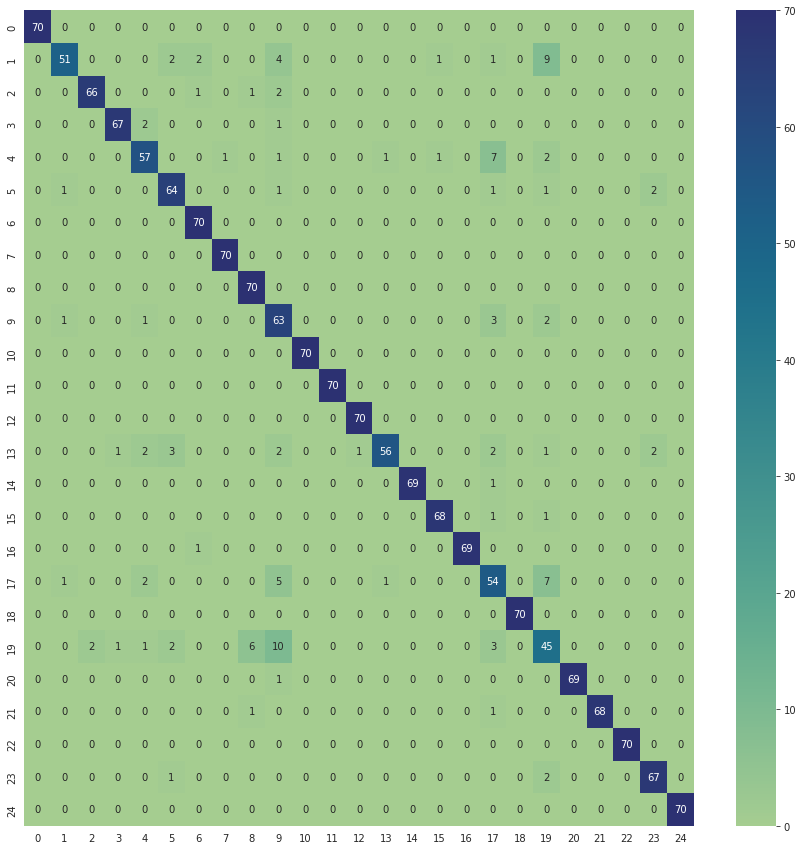

In [122]:
me.predict()
me.class_report()

#### Saving the essential data

In [123]:
malevis_models["InceptionResNetV2"] = {"Ground Truth": test.labels.tolist(), 
                                       "Predictions":np.array(me.predictions).tolist(), 
                                       "History": history.history}

### Blended Dataset

#### Model Training

In [124]:
model, history, test = experiment_model(cnns.inception_resnet_v2,
                                        "blended",blended_data_dir, 
                                        (75, 75),
                                        cnns.InceptionResNetV2(include_top=False, 
                                                               input_shape=(75, 75, 3)), 
                                        31, "val", 
                                        False, 5)

Found 7892 images belonging to 31 classes.
Found 3879 images belonging to 31 classes.
Found 1976 images belonging to 31 classes.
Epoch 1/80
247/247 [==============================] - 84s 270ms/step - loss: 0.7747 - accuracy: 0.7907 - auc: 0.9763 - false_positives: 599.0000 - precision: 0.9057 - recall: 0.7288 - val_loss: 7.2790 - val_accuracy: 0.6917 - val_auc: 0.9463 - val_false_positives: 681.0000 - val_precision: 0.7852 - val_recall: 0.6419
Epoch 2/80
247/247 [==============================] - 50s 203ms/step - loss: 0.3493 - accuracy: 0.9045 - auc: 0.9918 - false_positives: 422.0000 - precision: 0.9425 - recall: 0.8771 - val_loss: 1.0258 - val_accuracy: 0.8273 - val_auc: 0.9753 - val_false_positives: 436.0000 - val_precision: 0.8753 - val_recall: 0.7886
Epoch 3/80
247/247 [==============================] - 51s 206ms/step - loss: 0.2085 - accuracy: 0.9378 - auc: 0.9958 - false_positives: 308.0000 - precision: 0.9593 - recall: 0.9209 - val_loss: 0.2894 - val_accuracy: 0.9255 - val_auc

#### Model Evaluation

##### Initialization of the evaluator

In [125]:
me = ModelEvaluator(history, list(test.class_indices.keys()), model, test)

##### Training History

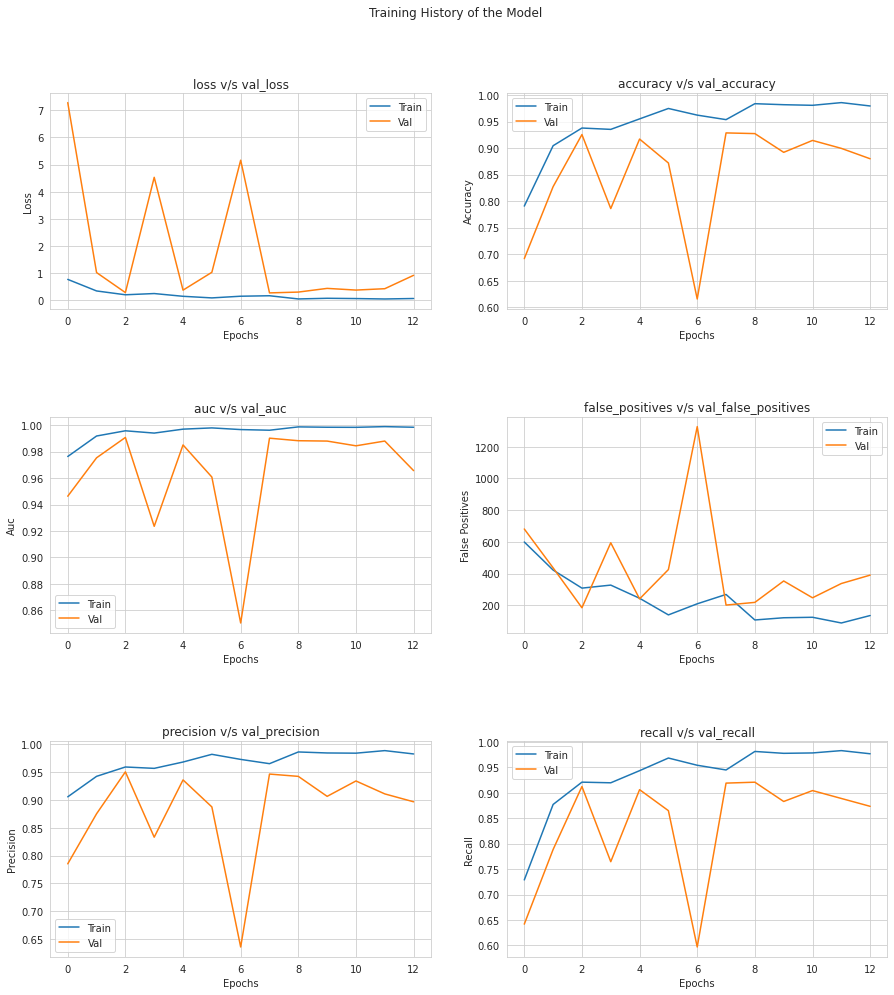

In [126]:
me.training_history()

##### Classification Metrics

                precision    recall  f1-score   support

      Adposhel       1.00      1.00      1.00        70
         Agent       0.76      0.83      0.79        70
       Allaple       0.97      0.94      0.96        70
 Alueron.gen!J       1.00      1.00      1.00        35
     Amonetize       0.85      0.96      0.90        70
        Androm       0.86      0.79      0.82        70
       Autorun       0.87      0.87      0.87        70
     BrowseFox       0.90      0.99      0.94        70
   C2LOP.gen!g       0.95      1.00      0.97        35
Dialplatform.B       1.00      1.00      1.00        31
        Dinwod       0.96      1.00      0.98        70
          Elex       0.97      0.97      0.97        70
        Expiro       0.80      0.67      0.73        70
      Fakerean       1.00      1.00      1.00        62
        Fasong       1.00      1.00      1.00        70
       HackKMS       1.00      1.00      1.00        70
          Hlux       1.00      1.00      1.00  

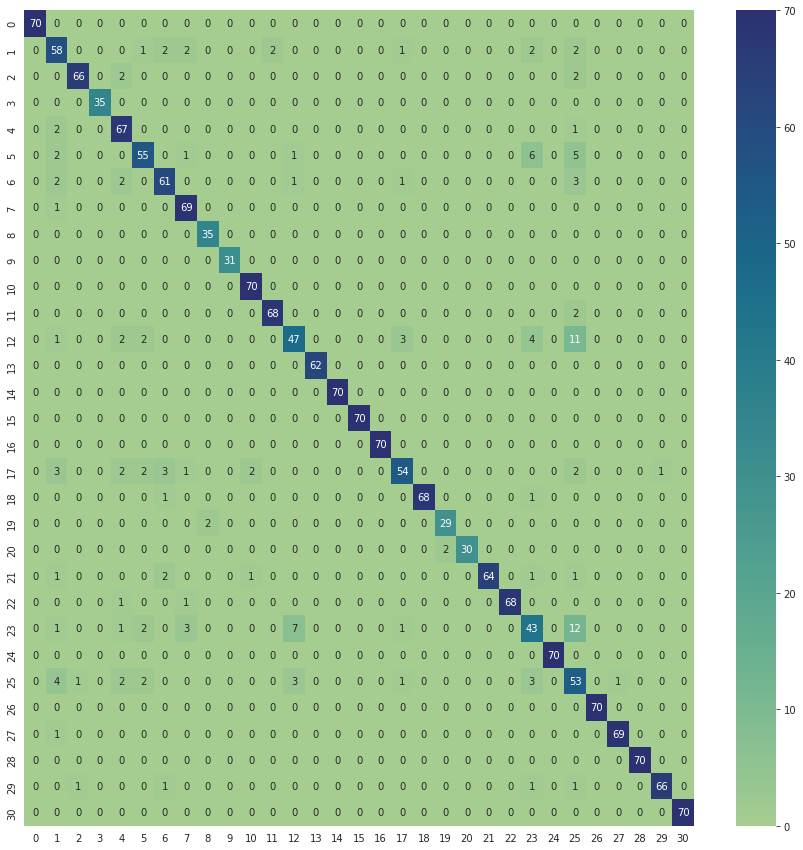

In [127]:
me.predict()
me.class_report()

#### Saving essential data

In [128]:
blended_models["InceptionResNetV2"] = {"Ground Truth": test.labels.tolist(), 
                                       "Predictions":np.array(me.predictions).tolist(), 
                                       "History": history.history}

# Saving all the model related information

In [129]:
# Serializing the model information for malimg dataset.
with open("/kaggle/working/malimg_models.json", 'w') as fp:
    json.dump(malimg_models, fp)

# Serializing the model information for malevis dataset.
with open("/kaggle/working/malevis_models.json", 'w') as fp:
    json.dump(malevis_models, fp)

# Serializing the model information for blended dataset.
with open("/kaggle/working/blended_models.json", 'w') as fp:
    json.dump(blended_models, fp)

# Model-wise Comparison

In [ ]:
# A class for model performance comparison for the particular dataset.
class ModelComparison:

    # Initialization of the class using the required parameters.
    def __init__(self, json_file_path : str, dataset : str):
        self.history = json.load(open(json_file_path, "r"))
        self.dataset = dataset
        self.colors = ["red", "orange", "yellow", "green", "blue", "black"]
        self.models = ['XceptionNet', 'EfficientNetB0', 'ResNet50', 'VGG16', 'DenseNet169', 'InceptionResNetV2']
    
    # Plotting a particular metric for all models.
    def __plot_metric(self, ax, metric: str):
        
        for model_idx in range(0, len(self.models)):
            ax.plot(self.history[self.models[model_idx]]["History"][metric], 
                    color=self.colors[model_idx])
                    
        ax.title.set_text(metric + " Comparison")
        ax.set_xlabel('Epochs')
        ax.set_ylabel(metric.title())
        ax.legend(self.models)
    
    # Plotting the comparative analysis of models based on
    # training history.
    def training_history(self):
        rows = 3
        columns = 2
        c = 0
        metrics = ["val_loss", "val_accuracy", "val_auc", "val_false_positives", "val_precision", "val_recall"]
        fig, axs = plt.subplots(rows, columns, 
                                figsize=(15,15))

        for metric in metrics:
            self.__plot_metric(axs[c//columns, c%columns], 
                               metric)
            c += 1

        fig.suptitle("Comparison of Model Performance on "+self.dataset)
        plt.subplots_adjust(bottom=0.1, 
                            top=0.9, hspace=0.5)
        plt.show()
  
    # Model Comparison based on Classification metrics.
    def compare_performance(self):
        accuracy = []
        f1 = []
        recall = []
        precision = []
        x = np.arange(len(self.models))

        for model_idx in range(0, len(self.models)):
            ground_truth = self.history[self.models[model_idx]]["Ground Truth"]
            predictions = self.history[self.models[model_idx]]["Predictions"]
            accuracy.append(round(accuracy_score(ground_truth, predictions),2))
            f1.append(round(f1_score(ground_truth, 
                                     predictions, 
                                     average="weighted"),
                            2))
            recall.append(round(recall_score(ground_truth, 
                                             predictions, 
                                             average="weighted"), 
                                2))
            precision.append(round(precision_score(ground_truth, 
                                                   predictions, 
                                                   average="weighted"), 
                                    2))
        
        plt.figure(figsize=(15,8))
        
        b1 = plt.bar(x, accuracy, 0.2, 
                     label = 'Accuracy', 
                     color="crimson", 
                     edgecolor="black")
        plt.bar_label(b1, accuracy)
        b2 = plt.bar(x+0.2, f1, 0.2, 
                     label = 'F1-score', 
                     color="yellow", 
                     edgecolor="black")
        plt.bar_label(b2, f1)
        b3 = plt.bar(x+0.4, recall, 0.2, 
                     label = 'Recall', 
                     color="orange", 
                     edgecolor="black")
        plt.bar_label(b3, recall)
        b4 = plt.bar(x+0.6, precision, 0.2, 
                     label = 'Precision', 
                     color="blue", 
                     edgecolor="black")
        plt.bar_label(b4, precision)

        plt.xticks(x+0.3, self.models)
        plt.xlabel("Models")
        plt.ylabel("Classification Metrics")
        plt.title("Classification Metrics for "+self.dataset+" across all models")
        plt.legend(loc='lower right')
        plt.show()

## Malimg Dataset

In [ ]:
malimg_model_comp = ModelComparison("/kaggle/working/malimg_models.json", 
                                    "Malimg dataset")

### Training History Comparison

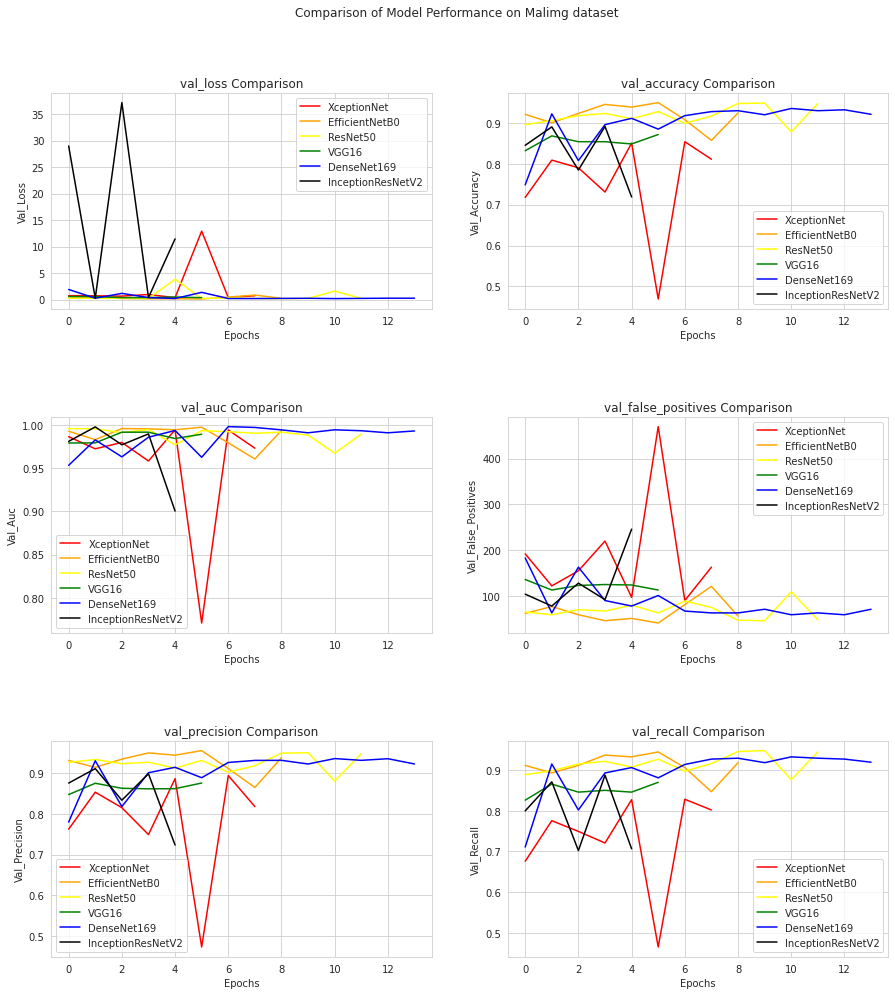

In [ ]:
malimg_model_comp.training_history()

### Classification Metrics-based comparison

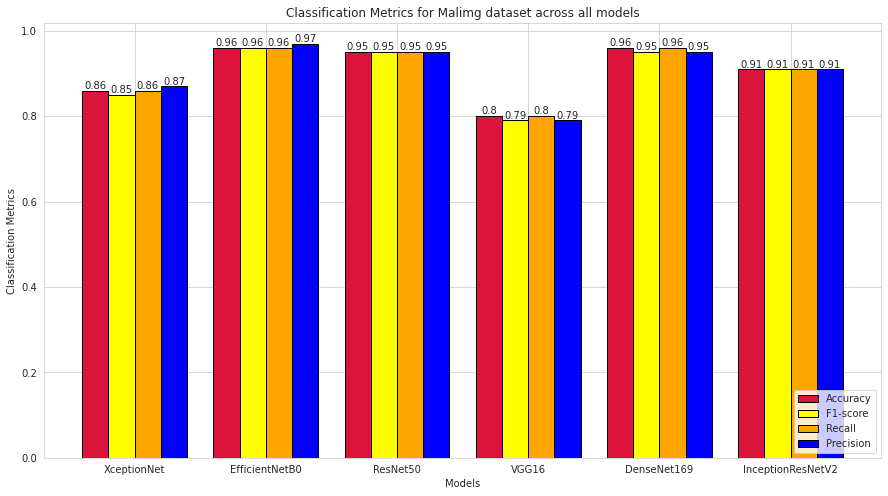

In [ ]:
malimg_model_comp.compare_performance()

## Malevis Dataset

In [ ]:
malevis_model_comp = ModelComparison("/kaggle/working/malevis_models.json", 
                                     "Malevis dataset")

### Training History Comparison

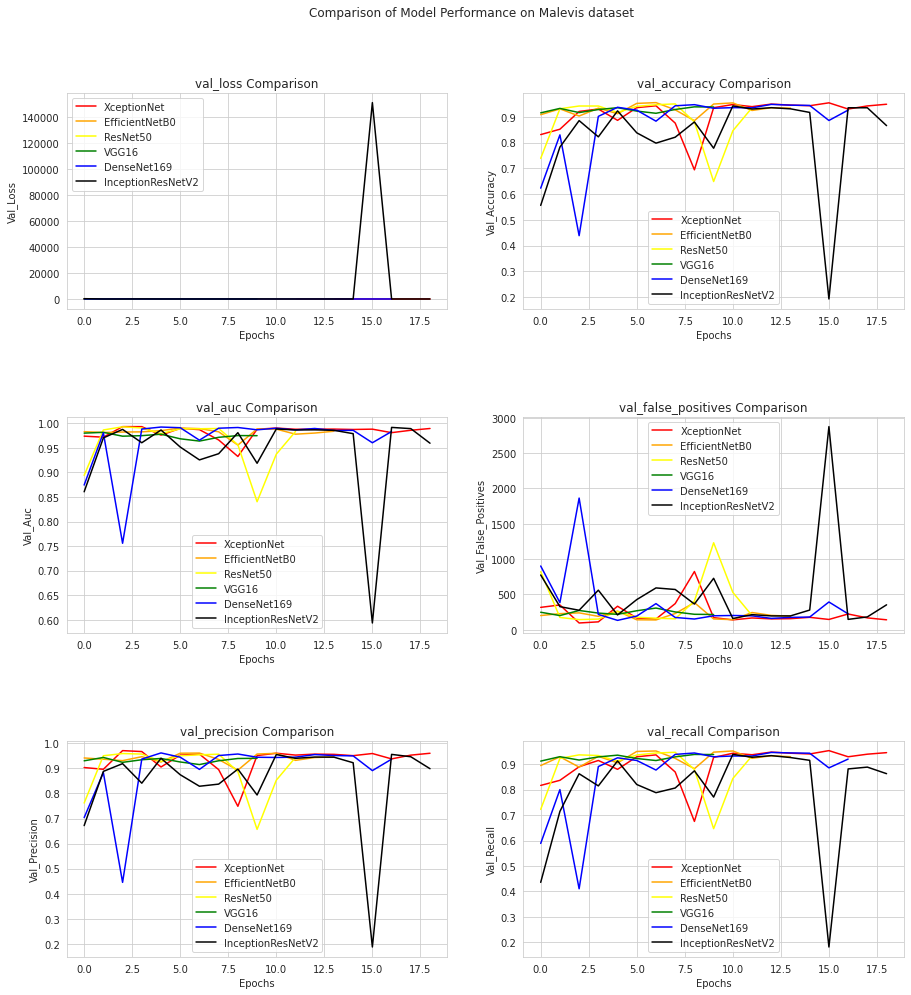

In [ ]:
malevis_model_comp.training_history()

### Classification Metrics-based comparison

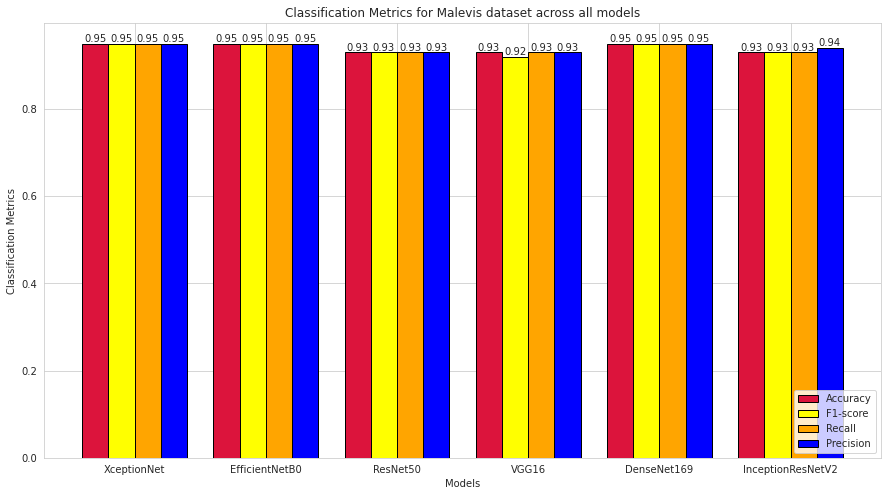

In [ ]:
malevis_model_comp.compare_performance()

## Blended Dataset

In [ ]:
blended_model_comp = ModelComparison("/kaggle/working/blended_models.json", 
                                     "Blended dataset")

### Training History based comparison

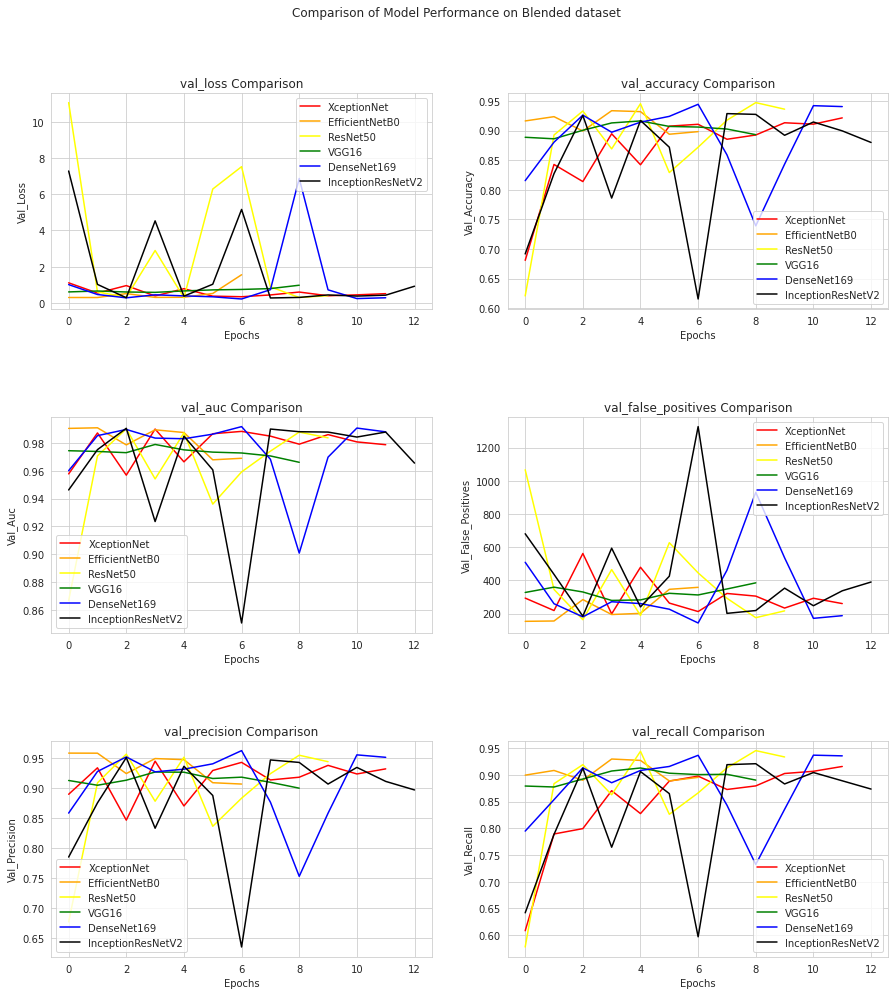

In [ ]:
blended_model_comp.training_history()

### Classification Metrics based comparison

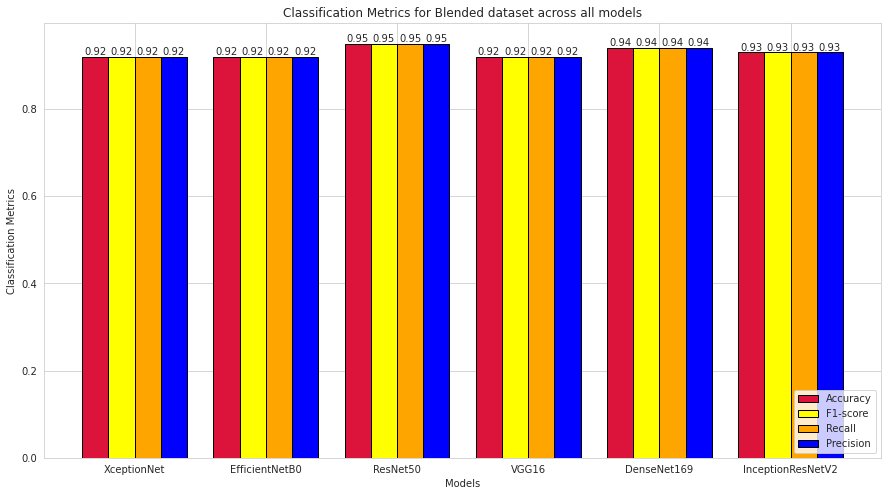

In [ ]:
blended_model_comp.compare_performance()

# Dataset Comparison vs Imbalance

In [ ]:
# A class for dataset imbalance based comparison.
class DatasetModelComparison:

    # Initialization of the dataset comparison using required parameters.
    def __init__(self, json_malimg : str, json_malevis : str, json_blended : str):
        self.malimg_history = json.load(open(json_malimg, "r"))
        self.malevis_history = json.load(open(json_malevis, "r"))
        self.blend_history = json.load(open(json_blended, "r"))
        self.datasets = ["malimg", "malevis", "blended"]
        self.models = ['XceptionNet', 'EfficientNetB0', 'ResNet50', 'VGG16', 'DenseNet169', 'InceptionResNetV2']
        self.dataset_colors = ["crimson", "orange", "yellow"]
        self.f1 = {"malimg":[], "malevis":[], "blended":[]}
        self.precision = {"malimg":[], "malevis": [], "blended": []}
        self.recall = {"malimg":[], "malevis": [], "blended": []}
    
    # Computation of the classification metrics.
    def __compute_classification_metrics(self):
        for dataset in self.datasets:
            history = {"malimg":self.malimg_history, "malevis":self.malevis_history, "blended":self.blend_history}
            for model in self.models:
                ground_truth = history[dataset][model]["Ground Truth"]
                predictions = history[dataset][model]["Predictions"]
                self.f1[dataset].append(round(f1_score(ground_truth, 
                                                       predictions, 
                                                       average="weighted"), 
                                              2))
                self.precision[dataset].append(round(precision_score(ground_truth, 
                                                                     predictions, 
                                                                     average="weighted"), 
                                                    2))
                self.recall[dataset].append(round(recall_score(ground_truth, 
                                                               predictions, 
                                                               average="weighted"), 
                                                 2))
    
    # Comparison of the model convergence based on data imbalance.
    def __convergence_comparison(self, ax):
        epochs = {"malimg":[], "malevis":[], "blended":[]}
        for model in self.models:
            epochs["malimg"].append(len(self.malimg_history[model]["History"]["loss"]))
            epochs["malevis"].append(len(self.malevis_history[model]["History"]["loss"]))
            epochs["blended"].append(len(self.blend_history[model]["History"]["loss"]))

        labels, data = epochs.keys(), epochs.values()
        bp = ax.boxplot(data, patch_artist=True)
        for element in ['boxes', 'whiskers', 'fliers', 'means', 'medians', 'caps']:
            plt.setp(bp[element], color="black")

        for patch,color in zip(bp['boxes'], self.dataset_colors):
            patch.set(facecolor=color)
            
        ax.set_xticks(range(1, len(labels) + 1), labels)
        ax.title.set_text("Dataset Convergence Comparison")
        ax.set_xlabel("Malware Image Datasets")
        ax.set_ylabel("Number of Epochs")
        ax.legend([bp["boxes"][0], bp["boxes"][1], bp["boxes"][2]], self.datasets)
    
    # Classification metrics based comparison
    def __metrics_comparison(self, ax, metric_data : dict, metric : str):
        labels, data = metric_data.keys(), metric_data.values()
        bp = ax.boxplot(data, patch_artist=True)
        for element in ['boxes', 'whiskers', 'fliers', 'means', 'medians', 'caps']:
            plt.setp(bp[element], color="black")

        for patch,color in zip(bp['boxes'], self.dataset_colors):
            patch.set(facecolor=color)
            
        ax.set_xticks(range(1, len(labels) + 1), labels)
        ax.title.set_text(metric.title()+" Comparison across datasets")
        ax.set_xlabel("Malware Image Datasets")
        ax.set_ylabel(metric.title())
        ax.legend([bp["boxes"][0], bp["boxes"][1], bp["boxes"][2]], self.datasets)
        
    # Plotting overall dataset-based comparison
    def compare_dataset_performance(self):
        self.__compute_classification_metrics()
        rows = 2
        columns = 2
        metrics = ["F1_score", "Precision", "Recall"]
        fig, axs = plt.subplots(rows, columns,figsize=(15,15))

        self.__convergence_comparison(axs[0,0])
        c = 1
        for metric, metric_data in zip(metrics, [self.f1, self.precision, self.recall]):
            self.__metrics_comparison(axs[c//columns, c%columns], 
                                      metric_data, metric)
            c += 1

        fig.suptitle("Comparison of Datasets based on Imbalance")
        plt.subplots_adjust(bottom=0.1, top=0.9, hspace=0.5)
        plt.show()
    
    # Heatmap for F1 score comparison.
    def compare_model_f1_scores(self):
        sns.heatmap(list(self.f1.values()), annot=True, 
                    xticklabels=self.models, yticklabels=list(self.f1.keys()),
                    linewidth=1, linecolor='w', square=True,
                    cmap="viridis")
    
    # Plotting a graph visualization for models and datasets.
    def plot_network_models_datasets(self):
        g = nx.Graph()
        
        for dataset, dcolor in zip(self.datasets, self.dataset_colors):
            g.add_node(dataset, color=dcolor, bipartite=0,)
        
        for model in self.models:
            g.add_node(model, color="blue", bipartite=1)
        
        for dataset in self.datasets:
            for model, f1_score in zip(self.models, self.f1[dataset]):
                if f1_score >= 0.9:
                    g.add_edge(dataset, model)
        
        plt.figure(figsize=(20,5))
        X, Y = bipartite.sets(g)
        pos = dict()
        pos.update((n, (1, i)) for i, n in enumerate(X))
        pos.update((n, (2, i)) for i, n in enumerate(Y))
        nx.draw_networkx_nodes(g, pos=pos,node_color="white",node_size=5)
        nx.draw_networkx_edges(g, pos=pos)
        nx.draw_networkx_labels(g, pos, font_color="k",font_size=10)
        
        plt.title("Models Performance on Datasets based on F1-score",font={"size":12})
        plt.show()

In [ ]:
model_comp = DatasetModelComparison("malimg_models.json", "malevis_models.json", "blended_models.json")

## Overall Dataset Comparison

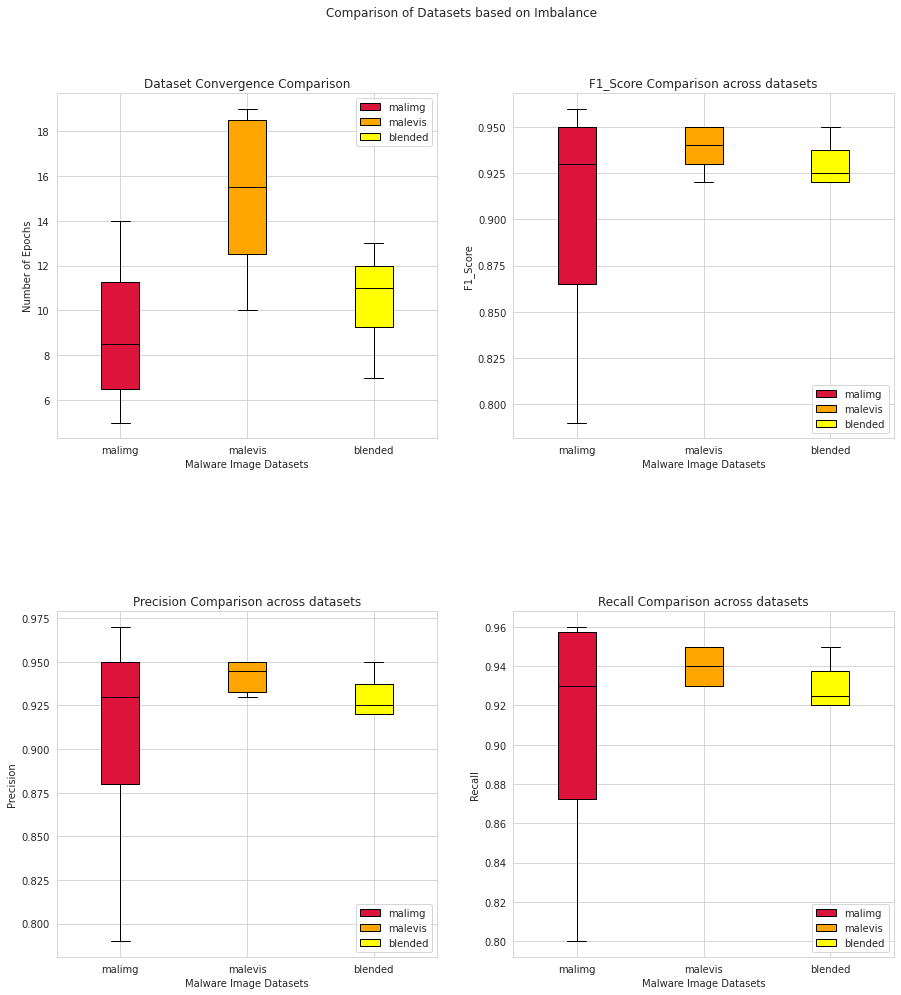

In [ ]:
model_comp.compare_dataset_performance()

## F1-score based comparison

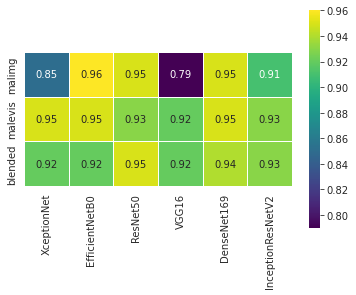

In [ ]:
model_comp.compare_model_f1_scores()

## Graph Visualization

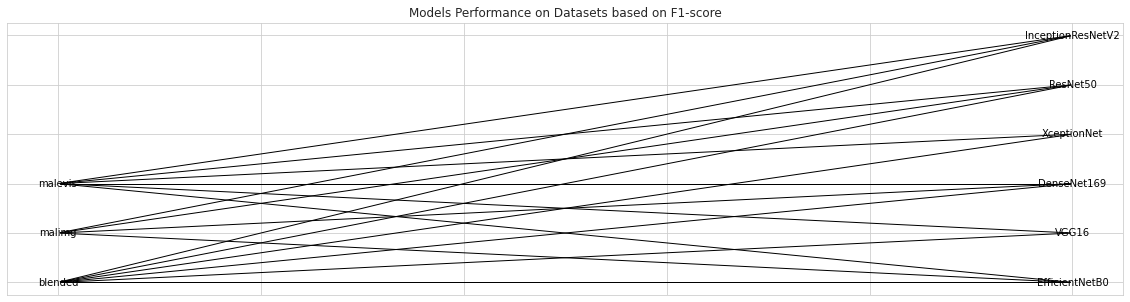

In [ ]:
model_comp.plot_network_models_datasets()